In [56]:
from __future__ import division
%pylab inline
from scipy import stats
from angles import r2d, r2arcs, d2arcs, arcs2r
def arcm2r(theta):
    return arcs2r(theta*60)
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import random
from collections import defaultdict
import treecorr
from itertools import chain
sns.set_context('poster',font_scale=1.4)
from lsst.sims.utils import angularSeparation

Populating the interactive namespace from numpy and matplotlib


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [39]:
proposalDict = {'baseline2018a':3, 'colossus_2664':2, 'colossus_2665':1, 'colossus_2667':1,
                'kraken_2026':3, 'kraken_2035':3, 'kraken_2036':3, 'kraken_2042':2, 'kraken_2044':1,
                'mothra_2045':1, 'nexus_2097':1, 'pontus_2002':1, 'pontus_2489':3, 'pontus_2502':2}

In [40]:
color = sns.color_palette('colorblind')

In [41]:
import seaborn
def corrplot(r, xi, sigma=np.array([None]),color='b',scale='log'):
    if sigma.all()!=None:

        ax = sns.tsplot(xi,r,color=color, n_boot=0)
        ax.errorbar(r, xi, yerr=sigma, fmt=None,color=color)

    else:
        sns.tsplot(xi,r,color=color)
    plt.xlabel(r'$\theta$ (degrees)')
    plt.xscale('log')
    plt.yscale(scale)


Main class:

In [5]:
ls /global/cscratch1/sd/husni/OpsimRuns/baseline2018a.db

/global/cscratch1/sd/husni/OpsimRuns/baseline2018a.db


In [60]:
countersDict.keys()

dict_keys(['pontus_2502', 'baseline2018a', 'colossus_2664', 'colossus_2665', 'colossus_2667', 'kraken_2026', 'kraken_2035', 'kraken_2036', 'kraken_2042', 'kraken_2044', 'mothra_2045', 'nexus_2097', 'pontus_2002', 'pontus_2489', 'rolling_10yrs_opsim', 'rolling_mix_10yrs_opsim'])

In [65]:
class ModelErrors():
    
    def __init__(self, ModelType, DitherPattern, rotDithers='random_filter', OpsimRun='minion_1016', objects_base='Y10', year=10):
        self.runName = '/global/cscratch1/sd/husni/OpsimRuns/'+OpsimRun 
        self.OpsimRun = OpsimRun
        if "minion" in self.OpsimRun:
            self.rundate = 'old'
        else:
            self.rundate = 'new'
        
        if 'rolling_10yrs_opsim' or OpsimRun=='rolling_mix_10yrs_opsim' in self.OpsimRun:
            self.Maker = 'Peter'
        # the available runs are 'minion_1012','minion_1016','alt_sched','feature_baseline_update_10yrsv2'
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.trace_ratio = 2.8933775060156068 # calculated in GalSize.ipynb
        self.PSF.TrM = self.TrM
        self.STAR.TrM = self.TrM
        self.FOVradius = 1.8 #degrees
        self.alpha = 0.01
        self.ModelType = ModelType
        self.star_num = 50000
        if 'minion' not in self.OpsimRun:
            try:
                if objects_base=='actual':
                    
                    stars_pos = np.load('newcutnpys/'+self.OpsimRun+str(object_year)+'.npy')
                elif objects_base=='Y10':
                    stars_pos = np.load('newcutnpys/'+self.OpsimRun+'10.npy')
                else:
                    raise ValueError('Cannot understand the base year, choose either "Y10" or "actual"')
            except:
                try: 
                    stars_pos = np.load('objs/'+self.OpsimRun+'.npy')
                
                except:
                    stars_pos = np.load('/global/cscratch1/sd/husni/OpsimRuns/'+self.OpsimRun+'.npy')
        else:
            stars_pos = np.load('objs/'+DitherPattern[0:-6]+'.npy')
            
        self.stars = np.array(random.sample(list(stars_pos),self.star_num))
        self.DELTA.e = defaultdict(np.array)
        self.DELTA.M = defaultdict(np.array)
        self.STAR.M = defaultdict(np.array)
        self.STAR.e = defaultdict(np.array)
        self.PSF.M = defaultdict(np.array)
        self.PSF.e = defaultdict(np.array)
        self.counter = defaultdict(int)
        self.ksstatistic = []
        self.pvalues = []
        if 'alt_sched' in self.OpsimRun:
            self.DitherPattern='field'
        self.DitherPatterns = {'random_night': 'randomDitherFieldPerNight', 'random_visit':'randomDitherFieldPerVisit',
                              'spiral_night': 'spiralDitherFieldPerNight', 'spiral_visit':'spiralDitherFieldPerVisit',
                              'hex_night': 'hexDitherFieldPerNight', 'hex_visit': 'hexDitherFieldPerVisit',
                              'field':'field'}
        if self.rundate=='new':
            fieldidcolumn = 'fieldId'
            deg = True
        else:
            fieldidcolumn = 'fieldID'
            deg = False
        self.Stackers = {'random_night':stackers.RandomDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'random_visit':stackers.RandomDitherFieldPerVisitStacker(degrees=deg),
                            'spiral_night':stackers.SpiralDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'spiral_visit':stackers.SpiralDitherFieldPerVisitStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'hex_night':stackers.HexDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'hex_visit':stackers.HexDitherFieldPerVisitStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'field':None} # choosing anything for field -- doesn't really matter
        if DitherPattern not in self.DitherPatterns.keys():
            raise ValueError('Dither Pattern not supported, please choose from:\
                                 field, random_night, random_visit, spiral_night, spiral_visit, hex_night, hex_visit')
        else:
            self.DitherPattern = self.DitherPatterns[DitherPattern]
            self.Stacker = [self.Stackers[DitherPattern]]
        self.rotDitherPattern = rotDithers
        if self.rotDitherPattern=='random_filter':
            pass
            #self.Stacker.append(stackers.RandomRotDitherPerFilterChangeStacker())

        self.savedStarsAngles = {tuple(k):[0] for k in self.stars}
        
        # Getting requirements on rho and xi_+ from HSC data. 
        HSCCosmicShear = np.loadtxt('HSCS16A_combinedarea_1000rea_full_xi_p.mean_sqrtvar')
        self.reqs_r = arcm2r(1)*HSCCosmicShear[:,0]
        self.HSCCosmicShear_xip = HSCCosmicShear[:,1]/2.6
        rho_reqs = np.loadtxt('rho_requirements.txt')
        lsst_area = 18000.
        hsc_area = 136.
        self.rho25_reqs = 0.02/self.alpha * np.sqrt(hsc_area/lsst_area) * rho_reqs[:,2]/(self.trace_ratio)**2
        self.rho134_reqs = np.sqrt(hsc_area/lsst_area) * rho_reqs[:,1]/(self.trace_ratio)
        self.year = year
      
    class PSF:
        '''empty namespace to organise results into
        '''
        pass
    
    class STAR:
        '''empty namespace to organise results into
        '''
        pass
    
    class DELTA:
        '''empty namespace to organise results into
        '''
        pass

    def getPositions(self,sqlWhere):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere
        '''
        print ('getting the dither positions from the database: ', self.DitherPattern)
        print ('using stackers:', self.Stacker)
        
        if self.DitherPattern=='field' and self.rotDitherPattern==None:
            
            opsdb = db.OpsimDatabase(self.runName+'.db')
            
            posRA = opsdb.fetchMetricData(['fieldRA'])
            posDec = opsdb.fetchMetricData(['fieldDec'])
            
            print

            if 'minion' not in self.OpsimRun:
                posRA = np.array([pos[0]*np.radians(1) for pos in posRA])
                posDec = np.array([pos[0]*np.radians(1) for pos in posDec])
            if self.Maker =='Peter':
                notes = opsdb.fetchMetricData(['note'])
                filters = opsdb.fetchMetricData(['filter'])
                filters = np.array([fil[0] for fil in filters])
                nights = opsdb.fetchMetricData(['night'])
                nights = np.array([n[0] for n in nights])
                ddf_cond = ['DD' not in (str(note)).split(':')[0] for note in notes]
                cond = np.logical_and.reduce((ddf_cond, filters=='i', nights<int(self.year*365)))
                # cond = np.logical_and(ddf_cond, filters=='i')
                # cond = filters=='i'
                posRA = posRA[cond]
                posDec = posDec[cond]
                        
            pos = np.array((posRA,posDec))
            
            self.positions = pos.swapaxes(1,0)
            
            return
        
        if self.Stacker[0]==None:
            self.Stacker=self.Stacker[1:]
        if 'minion' not in self.OpsimRun and 'feature' not in self.OpsimRun:
            print("new sim")
            outDir = 'dither_test'
            myBundles = {}
            nside = 128 
            resultsDb = db.ResultsDb(outDir=outDir)

            opsdb = db.OpsimDatabase(self.runName+'.db')
            slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec', nside=nside)
            
            metric = metrics.PassMetric()
            print(self.Stacker)
            if self.Stacker==[None]:
                myBundles['field dither'] = metricBundles.MetricBundle(metric, slicer, constraint=sqlWhere, 
                                                                    runName=self.runName,
                                                                    metadata='field dither')
            else:
                myBundles['field dither'] = metricBundles.MetricBundle(metric, slicer, constraint=sqlWhere, 
                                                                   stackerList=self.Stacker, runName=self.runName,
                                                                   metadata='field dither')
            bgroup = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)
            bgroup.runAll() 
        elif 'minion' in self.OpsimRun:
            print("old sims")
            opsdb = db.OpsimDatabaseV3(self.runName + '_sqlite.db')
            outDir = 'dither_test'
            resultsDb = db.ResultsDb(outDir=outDir)
            if self.DitherPattern=='field':
                slicer = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=False)
            else:
                slicer = slicers.HealpixSlicer(nside=64, lonCol=self.DitherPattern+'Ra', 
                                               latCol=self.DitherPattern+'Dec', latLonDeg=False)
            sqlconstraint = sqlWhere
            metric = metrics.CountMetric(col='night')

            bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=self.runName, 
                                            stackerList=self.Stacker)
            bgroup = metricBundles.MetricBundleGroup({self.DitherPattern+' dither':bundle}, 
                                                     opsdb, outDir=outDir, resultsDb=resultsDb)
            bgroup.runAll()
        if 'feature' in self.OpsimRun:
            if 'night < 365' in sqlWhere:
                print('year1')
                posRA, posDec = np.load('simruns/feature_baseline_y1.npy')
            else:    
                print('year10')
                posRA, posDec = np.load('simruns/feature_baseline.npy')
        elif self.DitherPattern=='field':
            posRA = bgroup.simData['fieldRA']
            posDec = bgroup.simData['fieldDec']
        else:
            posRA = bgroup.simData[self.DitherPattern+'Ra']
            posDec = bgroup.simData[self.DitherPattern+'Dec']
        pos = np.array((posRA,posDec))
        if 'minion' not in self.OpsimRun:
            pos *= np.radians(1)
        self.positions = pos.swapaxes(1,0)
        try:
            print('getting random rotational dithers')
            if np.logical_and(self.DitherPattern=='field', 'minion' in self.OpsimRun):
                self.rotTelPos = np.zeros(len(bgroup.simData['fieldDec']))
            else:
                self.rotTelPos = np.random.uniform(-np.pi/2,np.pi/2,len(bgroup.simData['fieldDec']))



        except: 
            print('not using rotational dithering')
            self.rotTelPos = None
        print ('Summary: we are using the OpsimRun at {}, with the translational dither pattern: {}. Rotation: {}'.format(self.runName,
                                                                                                                          self.DitherPattern,
                                                                                                                          self.rotDitherPattern))
        
    def M2e(self):
        ''' go back from 2nd moment space to elipticities
        '''
        print ('moving back from moment space to elipticities')
        for pos in self.PSF.M.keys():
            Mxx, Mxy, Myy = self.DELTA.M[pos]
            self.DELTA.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
            Mxx, Mxy, Myy = self.STAR.M[pos]
            self.STAR.e[pos] = np.array([(Mxx-Myy)/self.STAR.TrM, Mxy*2/self.STAR.TrM])
            Mxx, Mxy, Myy = self.PSF.M[pos]
            self.PSF.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
    
    def process(self,sqlWhere):
        ''' runs all analysis methods 
        '''
        self.getPositions(sqlWhere)
        print ('creating the models at every dither, this will take a while')
        for i in range(len(self.stars)):
            self.getModel(position_num=i)
        self.M2e()
        self.getRhos()
        self.rhos2errors()
        
    def unpack2XY(self, dictionaryitems):
        return map(lambda i: np.array([key[i] for key in dictionaryitems]), (0,1))

    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.
        '''
        print ('finding rhos')
        X, Y = self.unpack2XY(self.DELTA.e.keys())
        de1, de2 = self.unpack2XY(self.DELTA.e.values())
        psfe1, psfe2 = self.unpack2XY(self.PSF.e.values())
        stare1, stare2 = self.unpack2XY(self.STAR.e.values())
        condition= np.logical_and(np.logical_and(np.degrees(X)>5,np.degrees(Y)<-5), 
                                  np.logical_and(np.degrees(X)<195,np.degrees(Y)>-45))
        X = X[condition]
        Y = Y[condition]
        de1 = de1[condition]
        de2 = de2[condition]
        psfe1 = psfe1[condition]
        psfe2 = psfe2[condition]
        stare1 = stare1[condition]
        stare2 = stare2[condition]
        
        decat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y, 
                                 ra_units='radians', dec_units='radians')
        psfcat = treecorr.Catalog(g1=psfe1, g2=psfe2, ra=X, dec=Y, 
                                  ra_units='radians', dec_units='radians')
        starcat = treecorr.Catalog(g1=stare1, g2=stare2, ra=X, dec=Y, 
                                   ra_units='radians', dec_units='radians')
        
        min_sep=0.01 # in degrees
        max_sep=10 # in degrees
        nbins=24 # number of bins
        
        dedecorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                          nbins=nbins, sep_units='degrees')
        dedecorr.process(decat)
        dede_xip = dedecorr.xip
        dede_xim = dedecorr.xim
        self.rho1_sigma = dedecorr.varxi**0.5
        self.r = np.exp(dedecorr.meanlogr)
        self.rho1 = dede_xip
        self.rho1_im = dede_xim

        edecorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                         nbins=nbins, sep_units='degrees')
        edecorr.process(psfcat, decat)
        ede_xip = edecorr.xip
        ede_xim = edecorr.xim
        
        self.rho2 = ede_xip
        self.rho2_im = ede_xim
        self.rho2_sigma = edecorr.varxi**0.5
        

        self.size_error_ratio = 0.001

        edtedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                            nbins=nbins, sep_units='degrees')
        edtedtcorr.process(psfcat, psfcat)
        edtedt_xip = edtedtcorr.xip * self.size_error_ratio**2
        edtedt_xim = edtedtcorr.xim * self.size_error_ratio**2

        self.rho3 = edtedt_xip
        self.rho3_im = edtedt_xim
        self.rho3_sigma = edtedtcorr.varxi**0.5 * self.size_error_ratio**2

        deedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                           nbins=nbins, sep_units='degrees')
        deedtcorr.process(decat, psfcat)
        deedt_xip = deedtcorr.xip * self.size_error_ratio
        deedt_xim = deedtcorr.xim * self.size_error_ratio

        self.rho4 = deedt_xip
        self.rho4_im = deedt_xim
        self.rho4_sigma = deedtcorr.varxi**0.5 * self.size_error_ratio

        eedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                          nbins=nbins, sep_units='degrees')
        eedtcorr.process(psfcat, psfcat)
        eedt_xip = eedtcorr.xip * self.size_error_ratio
        eedt_xim = eedtcorr.xim * self.size_error_ratio

        self.rho5 = eedt_xip
        self.rho5_im = eedt_xim
        self.rho5_sigma = eedtcorr.varxi**0.5 * self.size_error_ratio
            
        # star shape correlation:
        starcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, 
                                          nbins=nbins, sep_units='degrees')
        starcorr.process(starcat)
        self.xip_sigma = starcorr.varxi**0.5
        self.xip = starcorr.xip
        self.xim = starcorr.xim
        
    def rhos2errors(self):
        ''' propagates rho statistics into shear errors 
        '''

        self.delta_xip = 2 * (self.size_error_ratio * self.trace_ratio) * self.xip\
                    + (self.trace_ratio)**2 * self.rho1\
                    - self.alpha * (self.trace_ratio) * self.rho2\
                    + (self.trace_ratio)**2 * self.rho3\
                    + (self.trace_ratio)**2 * self.rho4\
                    - self.alpha * (self.trace_ratio) * self.rho5
        
        self.delta_xip_sigma = np.sqrt( self.trace_ratio**4 * self.rho1_sigma**2 \
                                      + self.alpha**2 * self.trace_ratio**2 * self.rho2_sigma**2 \
                                      + 4 * self.size_error_ratio**2 *self.trace_ratio**2 * self.xip_sigma**2 \
                                      + self.trace_ratio**4 * self.rho3_sigma**2 \
                                      + self.trace_ratio**4 * self.rho4_sigma**2 \
                                      + self.alpha**2 * self.trace_ratio**2 * self.rho5_sigma**2)
                                  
    def getModel(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin.
            New algorithm loops over each star, finding the dither positions at which it would
            be visible -- then 
        '''
        from angles import r2d, r2arcs, d2arcs
        star_pos = self.stars[position_num]
        cond = angularSeparation(self.positions[:,0]*np.degrees(1),self.positions[:,1]*np.degrees(1),
                                                         star_pos[0]*np.degrees(1), star_pos[1]*np.degrees(1))<self.FOVradius
        innerDithers = self.positions[cond]
        if len(innerDithers) < 2:
            return
        
        try:
            rotDithers = self.rotTelPos[cond]
        except: pass
        

        if self.ModelType == 'radial':
            stare1, stare2, psfe1, psfe2 = self.RadialModel(star_pos=star_pos, innerDithers=innerDithers)
        elif self.ModelType == 'horizontal':
            stare1, stare2, psfe1, psfe2 = self.HorizontalModel(star_pos=star_pos, innerDithers=innerDithers, rotDithers=rotDithers)
        star_pos = tuple(star_pos)
        starMxx = 0.5*self.STAR.TrM*(stare1+1)
        starMxy = 0.5*self.STAR.TrM*stare2
        starMyy = 0.5*self.STAR.TrM*(-stare1+1)
        psfMxx = 0.5*self.PSF.TrM*(psfe1+1)
        psfMxy = 0.5*self.PSF.TrM*psfe2
        psfMyy = 0.5*self.PSF.TrM*(-psfe1+1)
        angles = np.array([r2d(0.5*np.arctan2(e2,e1)) for e2,e1 in zip(stare2,stare1)]) 
        # self.savedStarsAngles[star_pos] = angles

        deltaMxx = starMxx - psfMxx
        deltaMxy = starMxy - psfMxy
        deltaMyy = starMyy - psfMyy

        self.counter[star_pos] = len(innerDithers)
        self.STAR.M[star_pos] = np.array([np.mean(starMxx), np.mean(starMxy), np.mean(starMyy)])
        self.PSF.M[star_pos] = np.array([np.mean(psfMxx), np.mean(psfMxy), np.mean(psfMyy)])
        self.DELTA.M[star_pos] = np.array([np.mean(deltaMxx), np.mean(deltaMxy), np.mean(deltaMyy)])

    def RadialModel(self, star_pos, innerDithers):
        
        r = angularSeparation(star_pos[0]*np.degrees(1), star_pos[1]*np.degrees(1), 
                              innerDithers[:,0]*np.degrees(1), innerDithers[:,1]*np.degrees(1))
        r *= np.radians(1)
        r[r<0.0237]=0 # 0.0237 is 80% of the LSST FOV radius in radians.
        r[r>=0.0237]=0.08
        rel_X, rel_Y = star_pos[0] - innerDithers[:,0], star_pos[1] - innerDithers[:,1]
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)
        stare2 = r*np.sin(2*theta)
        psfe1 = stare1/1.06
        psfe2 = stare2/1.06
        return stare1, stare2, psfe1, psfe2

    def HorizontalModel(self, star_pos, innerDithers, rotDithers):
        '''this method creates a radial model of e_psf = 0.6 and the residual is 3%.'''
        stare1 = np.cos(2*rotDithers)/5
        stare2 = np.sin(2*rotDithers)/5
        psfe1 = stare1/1.03
        psfe2 = stare2/1.03
        return stare1, stare2, psfe1, psfe2

In [55]:
%%time
for OpsimRun in ['rolling_10yrs_opsim']:
    counter = getDeltaXips(n=1, model='radial', year=10, DitherPattern='field', OpsimRun=OpsimRun, rotDithers=None, overwrite=True, objects_base='Y10')

rolling_10yrs_opsim
getting the dither positions from the database:  field
using stackers: [None]
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
CPU times: user 38min 22s, sys: 10.1 s, total: 38min 32s
Wall time: 38min 32s


In [ ]:
for year in [1,3,6,10]:
    for objects_base in ['Y10', 'actual']:
        counter = {}
        for run in ['baseline2018a', 'colossus_2664', 'colossus_2665', 'colossus_2667', 
                    'kraken_2026', 'kraken_2035', 'kraken_2036', 'kraken_2042', 'kraken_2044', 
                    'mothra_2045', 'nexus_2097', 'pontus_2002', 
                    'pontus_2489', 'mothra_2049']:
            counter[run] = getDeltaXips(n=1, model='radial', year=year, DitherPattern='random_visit', 
                                   OpsimRun=run, rotDithers=None, overwrite=True, objects_base=objects_base)
        for run in ['rolling_10yrs_opsim', 'rolling_mix_10yrs_opsim']:
            counter[run] = getDeltaXips(n=1, model='radial', year=year, DitherPattern='field', 
                                   OpsimRun=run, rotDithers=None, overwrite=True, objects_base=objects_base)
        countername = 'counter'+str(year)+'_'+str(objects_base)+'.p'
        pickle.dump(counter, open(countername, 'wb'))

baseline2018a
getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStackers.RandomDitherFieldPerVisitStacker object at 0x2abe7fef11d0>]
new sim
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint night < 365 and filter = "i" for columns ['fieldDec', 'fieldRA']
Found 30745 visits
Running:  ['field dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
getting random rotational dithers
Summary: we are using the OpsimRun at /global/cscratch1/sd/husni/OpsimRuns/baseline2018a, with the translational dither pattern: randomDitherFieldPerVisit. Rotation: None
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
colossus_2664
getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.dith

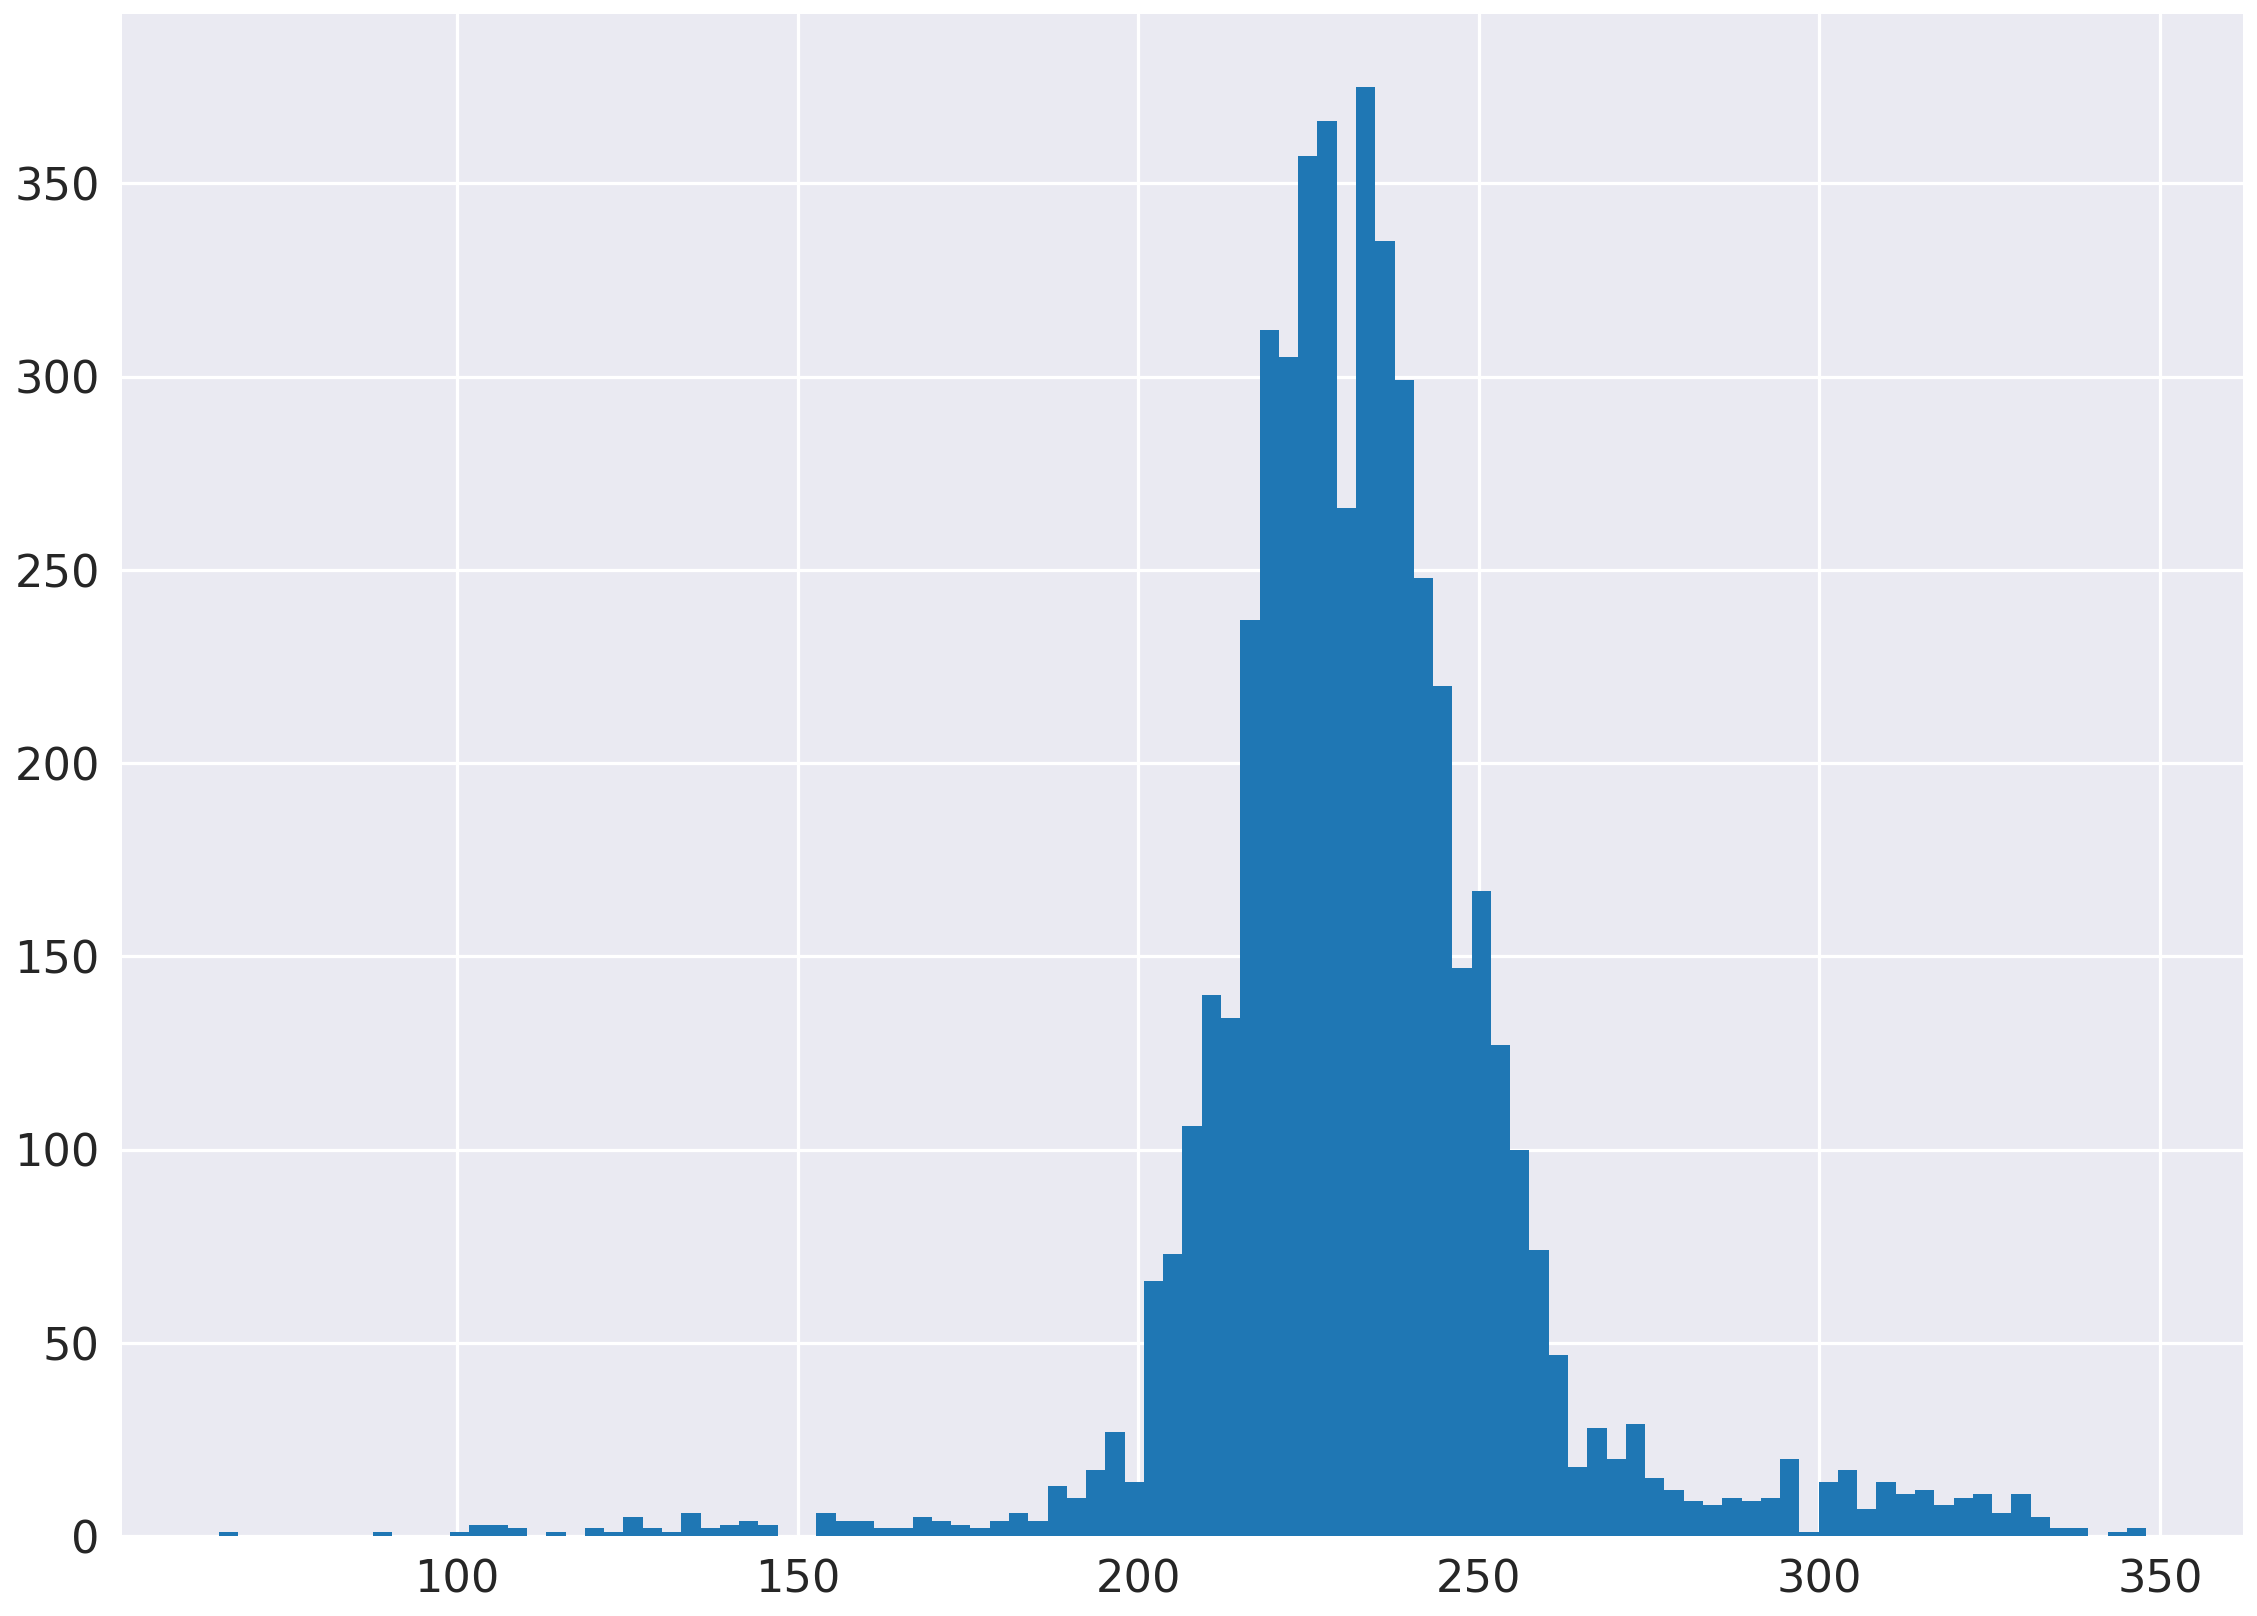

In [30]:
plt.hist([i for i in list(counter['rolling_10yrs_opsim'].values()) if i<1000], 100);

In [54]:
def getDeltaXips(n, model, year, DitherPattern, OpsimRun, rotDithers, objects_base, overwrite=False):
    """
    n is the number of runs this function should run
    model can be 'radial' or 'horizontal'
    DitherPattern can be 'field' or 'spiral', 'hexagonal', 'random'
    OpsimRun is the name of the .db file without the exetension
    rotDithers can be None or 'random_filter'
    sqlWhere is the sql constraints when querying the database
    """
    countersDict = {}
    nightsNum = year*365
    sqlWhere = 'night < '+str(nightsNum)+' and filter = "i" and proposalId = '+str(proposalDict[OpsimRun])
    directory = 'newcutnpys/'
    outName = directory+OpsimRun+DitherPattern+str(year)+'.npy'
    if overwrite==False:
        delta_xips = np.load(outName)
        for i in range(n):
            errors_object = ModelErrors(ModelType=model, DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers, year=year, objects_base=objects_base)
            errors_object.process(sqlWhere)
            countersDict[OpsimRun] = errors_object.counter
            delta_xips = np.vstack((delta_xips, errors_object.delta_xip))
            np.save(outName, delta_xips)
            
    else:
        print(OpsimRun)
        errors_object = ModelErrors(ModelType=model, DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers, year=year, objects_base=objects_base)
        errors_object.process(sqlWhere)
        countersDict[OpsimRun] = errors_object.counter
        np.save(outName, errors_object.delta_xip)
        if n>1:
            delta_xips = np.load(outName)
            for i in n-1:
                errors_object = ModelErrors(ModelType=model, DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers, year=year, objects_base=objects_base)
                errors_object.process(sqlWhere)
                countersDict[OpsimRun] = errors_object.counter
                delta_xips = np.vstack((delta_xips, errors_object.delta_xip))
                np.save(outName, delta_xips)
    
    return countersDict        
    print('there are now {} runs total for this strategy'.format(len(np.load(outName))))

In [21]:
countersDict = {}

In [48]:
sum([i for i in list((countersDict['pontus_2489']).values())])

1530092

In [24]:
np.array({1:'1'})

array({1: '1'}, dtype=object)

In [72]:
sns.set_palette('Paired',8)

baseline2018a 45.61607007360454 1060924 4.29965483612441e-05
colossus_2664 43.01258122921711 1035420 4.154119220144203e-05
colossus_2665 46.101015865596715 1049602 4.392237806863622e-05
colossus_2667 48.46007449573167 1088195 4.453252817347228e-05
kraken_2026 46.09406460315688 1095797 4.2064419416330655e-05
kraken_2035 44.538606163641894 1054345 4.224291495064888e-05
kraken_2036 37.23598352078269 888841 4.189273843216356e-05
kraken_2042 49.17013320095849 1178505 4.172246464882074e-05
kraken_2044 41.00327644274296 809468 5.065459838158267e-05
mothra_2045 34.61781337461972 663923 5.214130761341258e-05
nexus_2097 39.59334033647578 794245 4.9850285914894996e-05
pontus_2002 40.28030605643408 803060 5.015852620779777e-05
pontus_2489 64.85086808239348 1529082 4.2411635270308246e-05
pontus_2502 31.71130824106757 894079 3.54681278064551e-05


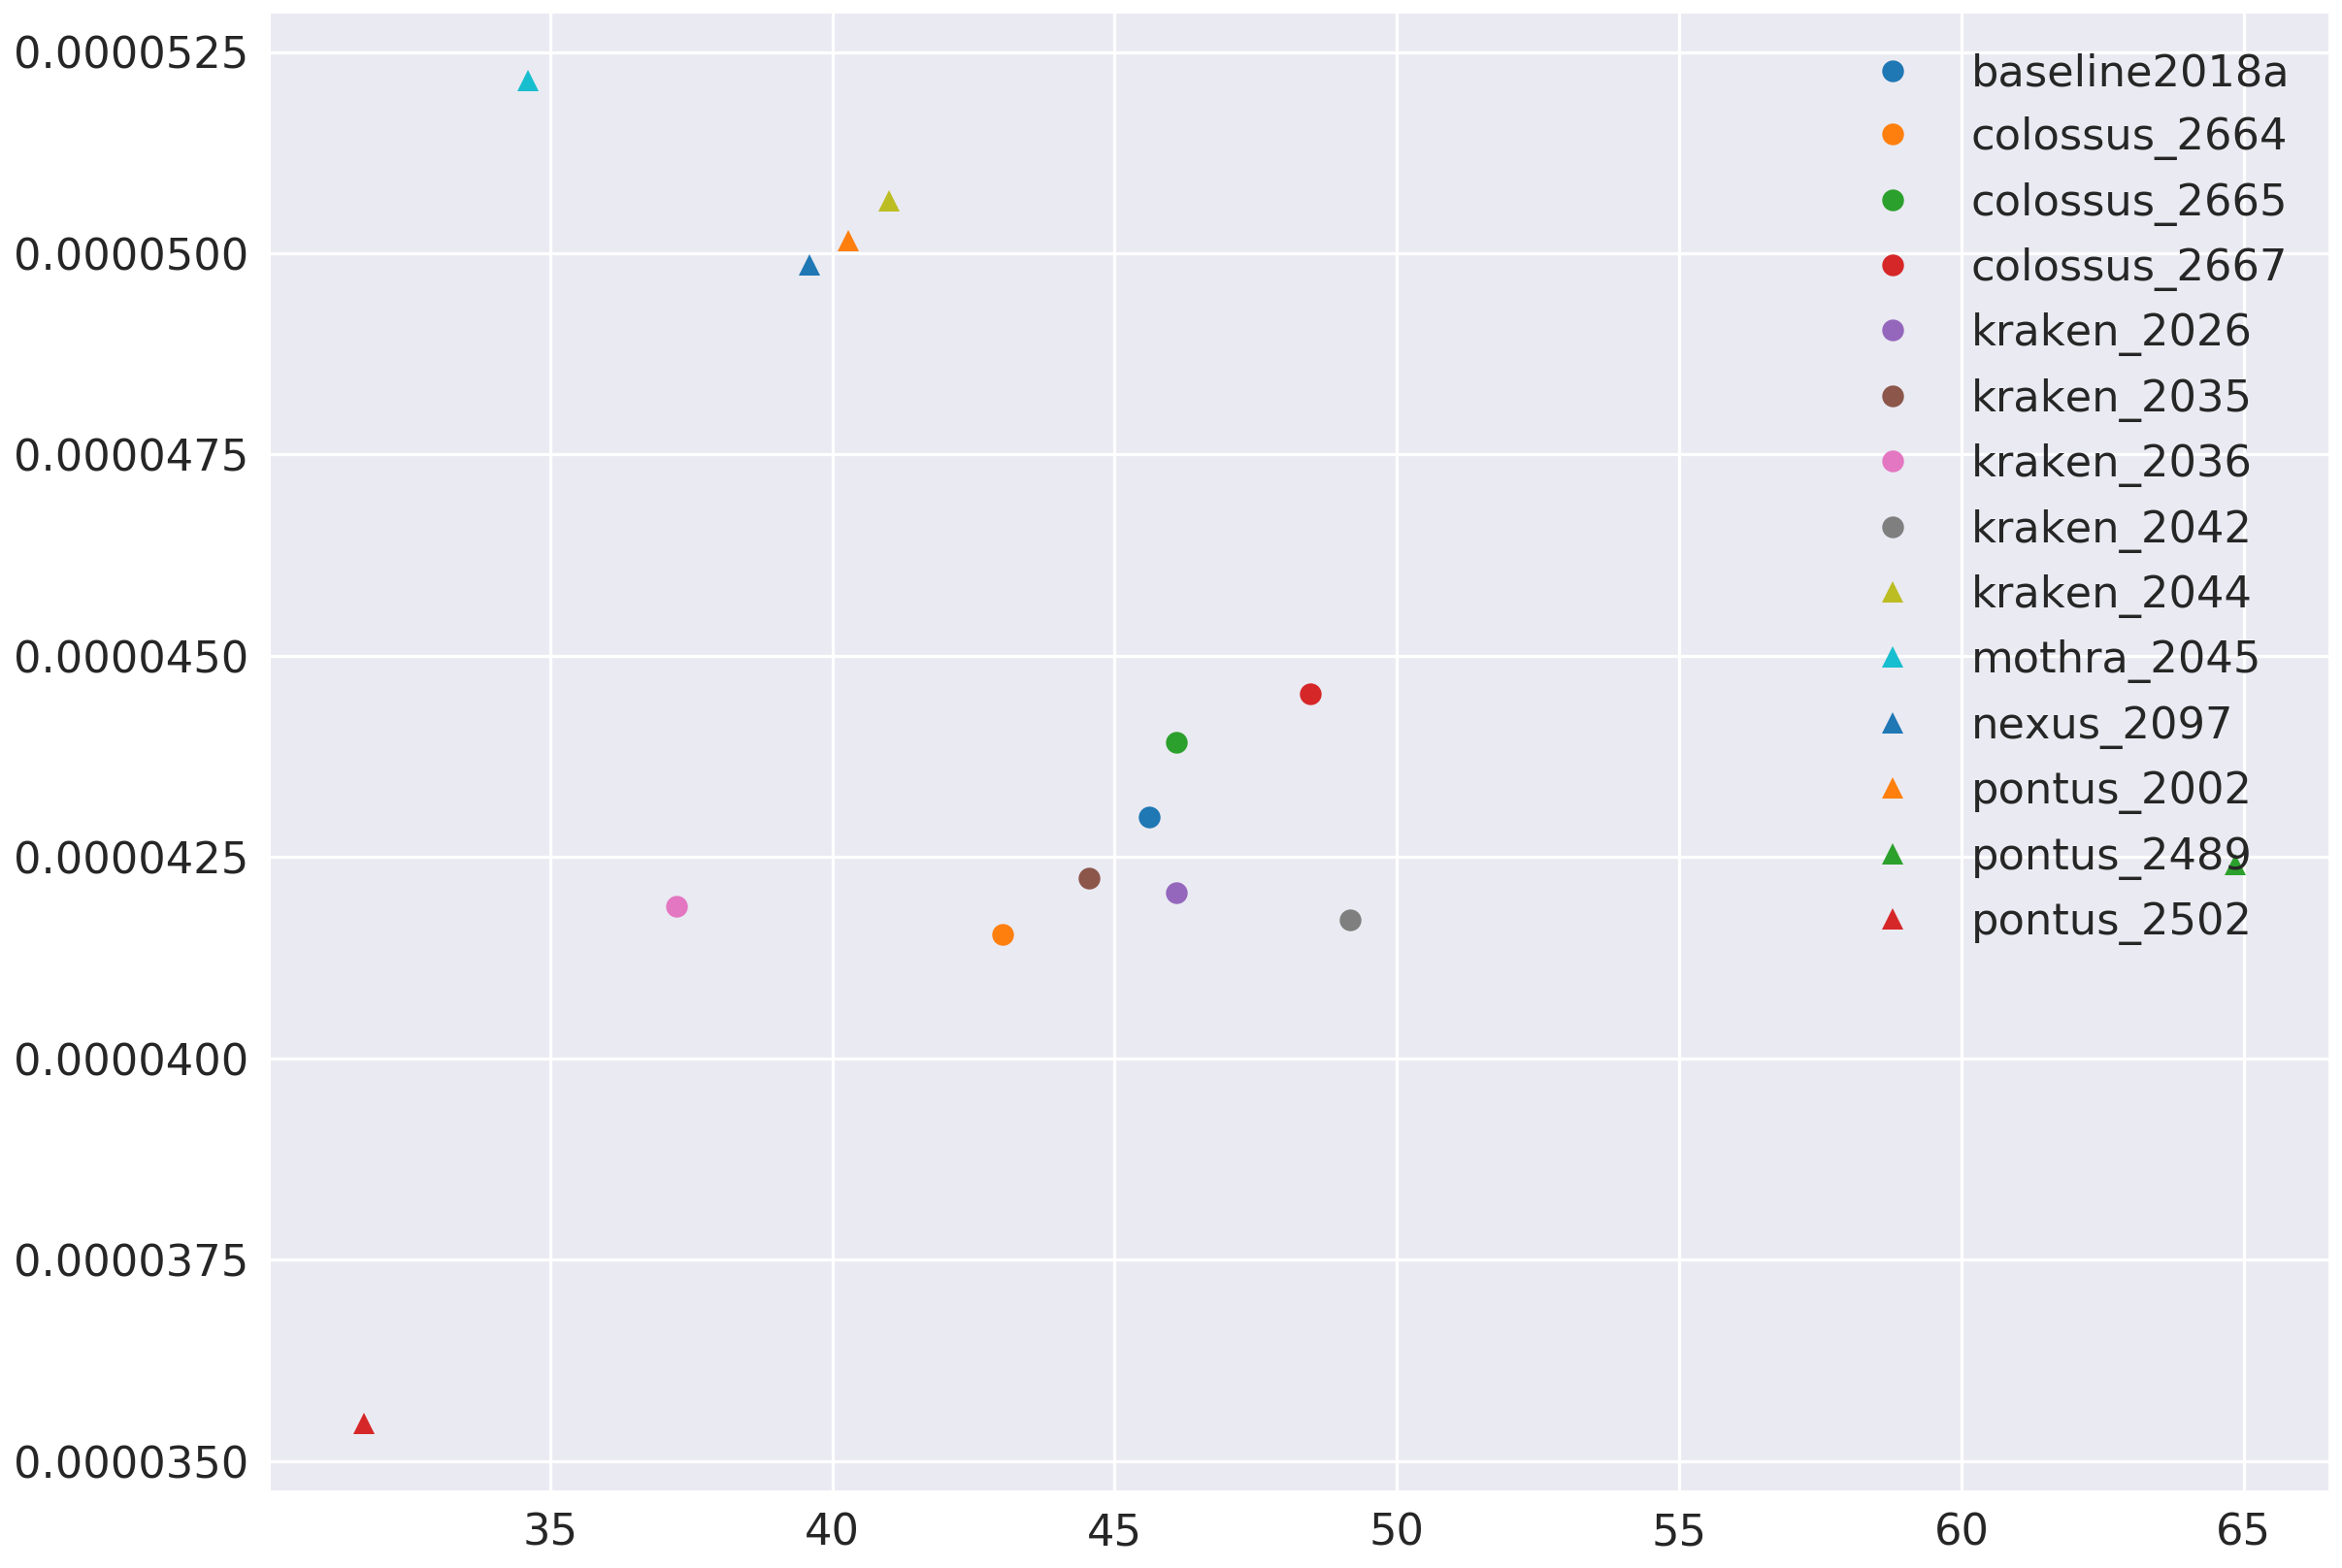

In [19]:
for OpsimRun in list(proposalDict.keys())[0:8]:
    a = np.std(list(countersDict[OpsimRun].values()))
    b = np.sum(list(countersDict[OpsimRun].values()))
    print(OpsimRun, a, b, a/b)
    plt.plot(a, a/b, 'o', label=OpsimRun)
for OpsimRun in list(proposalDict.keys())[8:]:
    a = np.std(list(countersDict[OpsimRun].values()))
    b = np.sum(list(countersDict[OpsimRun].values()))
    print(OpsimRun, a, b, a/b)
    plt.plot(a, a/b, '^', label=OpsimRun)

plt.legend()

In [84]:
for OpsimRun in list(countersDict.keys()):
    print(OpsimRun, np.std(list(countersDict[OpsimRun].values())))

pontus_2502 31.71130824106757
baseline2018a 45.61607007360454
colossus_2664 43.01258122921711
colossus_2665 46.101015865596715
colossus_2667 48.46007449573167
kraken_2026 46.09406460315688
kraken_2035 44.538606163641894
kraken_2036 37.23598352078269
kraken_2042 49.17013320095849
kraken_2044 41.00327644274296
mothra_2045 34.61781337461972
nexus_2097 39.59334033647578
pontus_2002 40.28030605643408
pontus_2489 64.85086808239348
rolling_10yrs_opsim 43.51752823863047
rolling_mix_10yrs_opsim 42.238937721491055


In [92]:
len([[1]][0])

1

In [78]:
for OpsimRun in list(countersDict.keys()):
    print(OpsimRun, np.mean(list(countersDict[OpsimRun].values())))

pontus_2502 178.8158
baseline2018a 212.1848
colossus_2664 207.084
colossus_2665 209.9204
colossus_2667 219.21736502820306
kraken_2026 219.1594
kraken_2035 210.869
kraken_2036 177.7682
kraken_2042 235.701
kraken_2044 161.8936
mothra_2045 132.7846
nexus_2097 158.849
pontus_2002 160.612
pontus_2489 305.8164
rolling_10yrs_opsim 202.444
rolling_mix_10yrs_opsim 193.5504


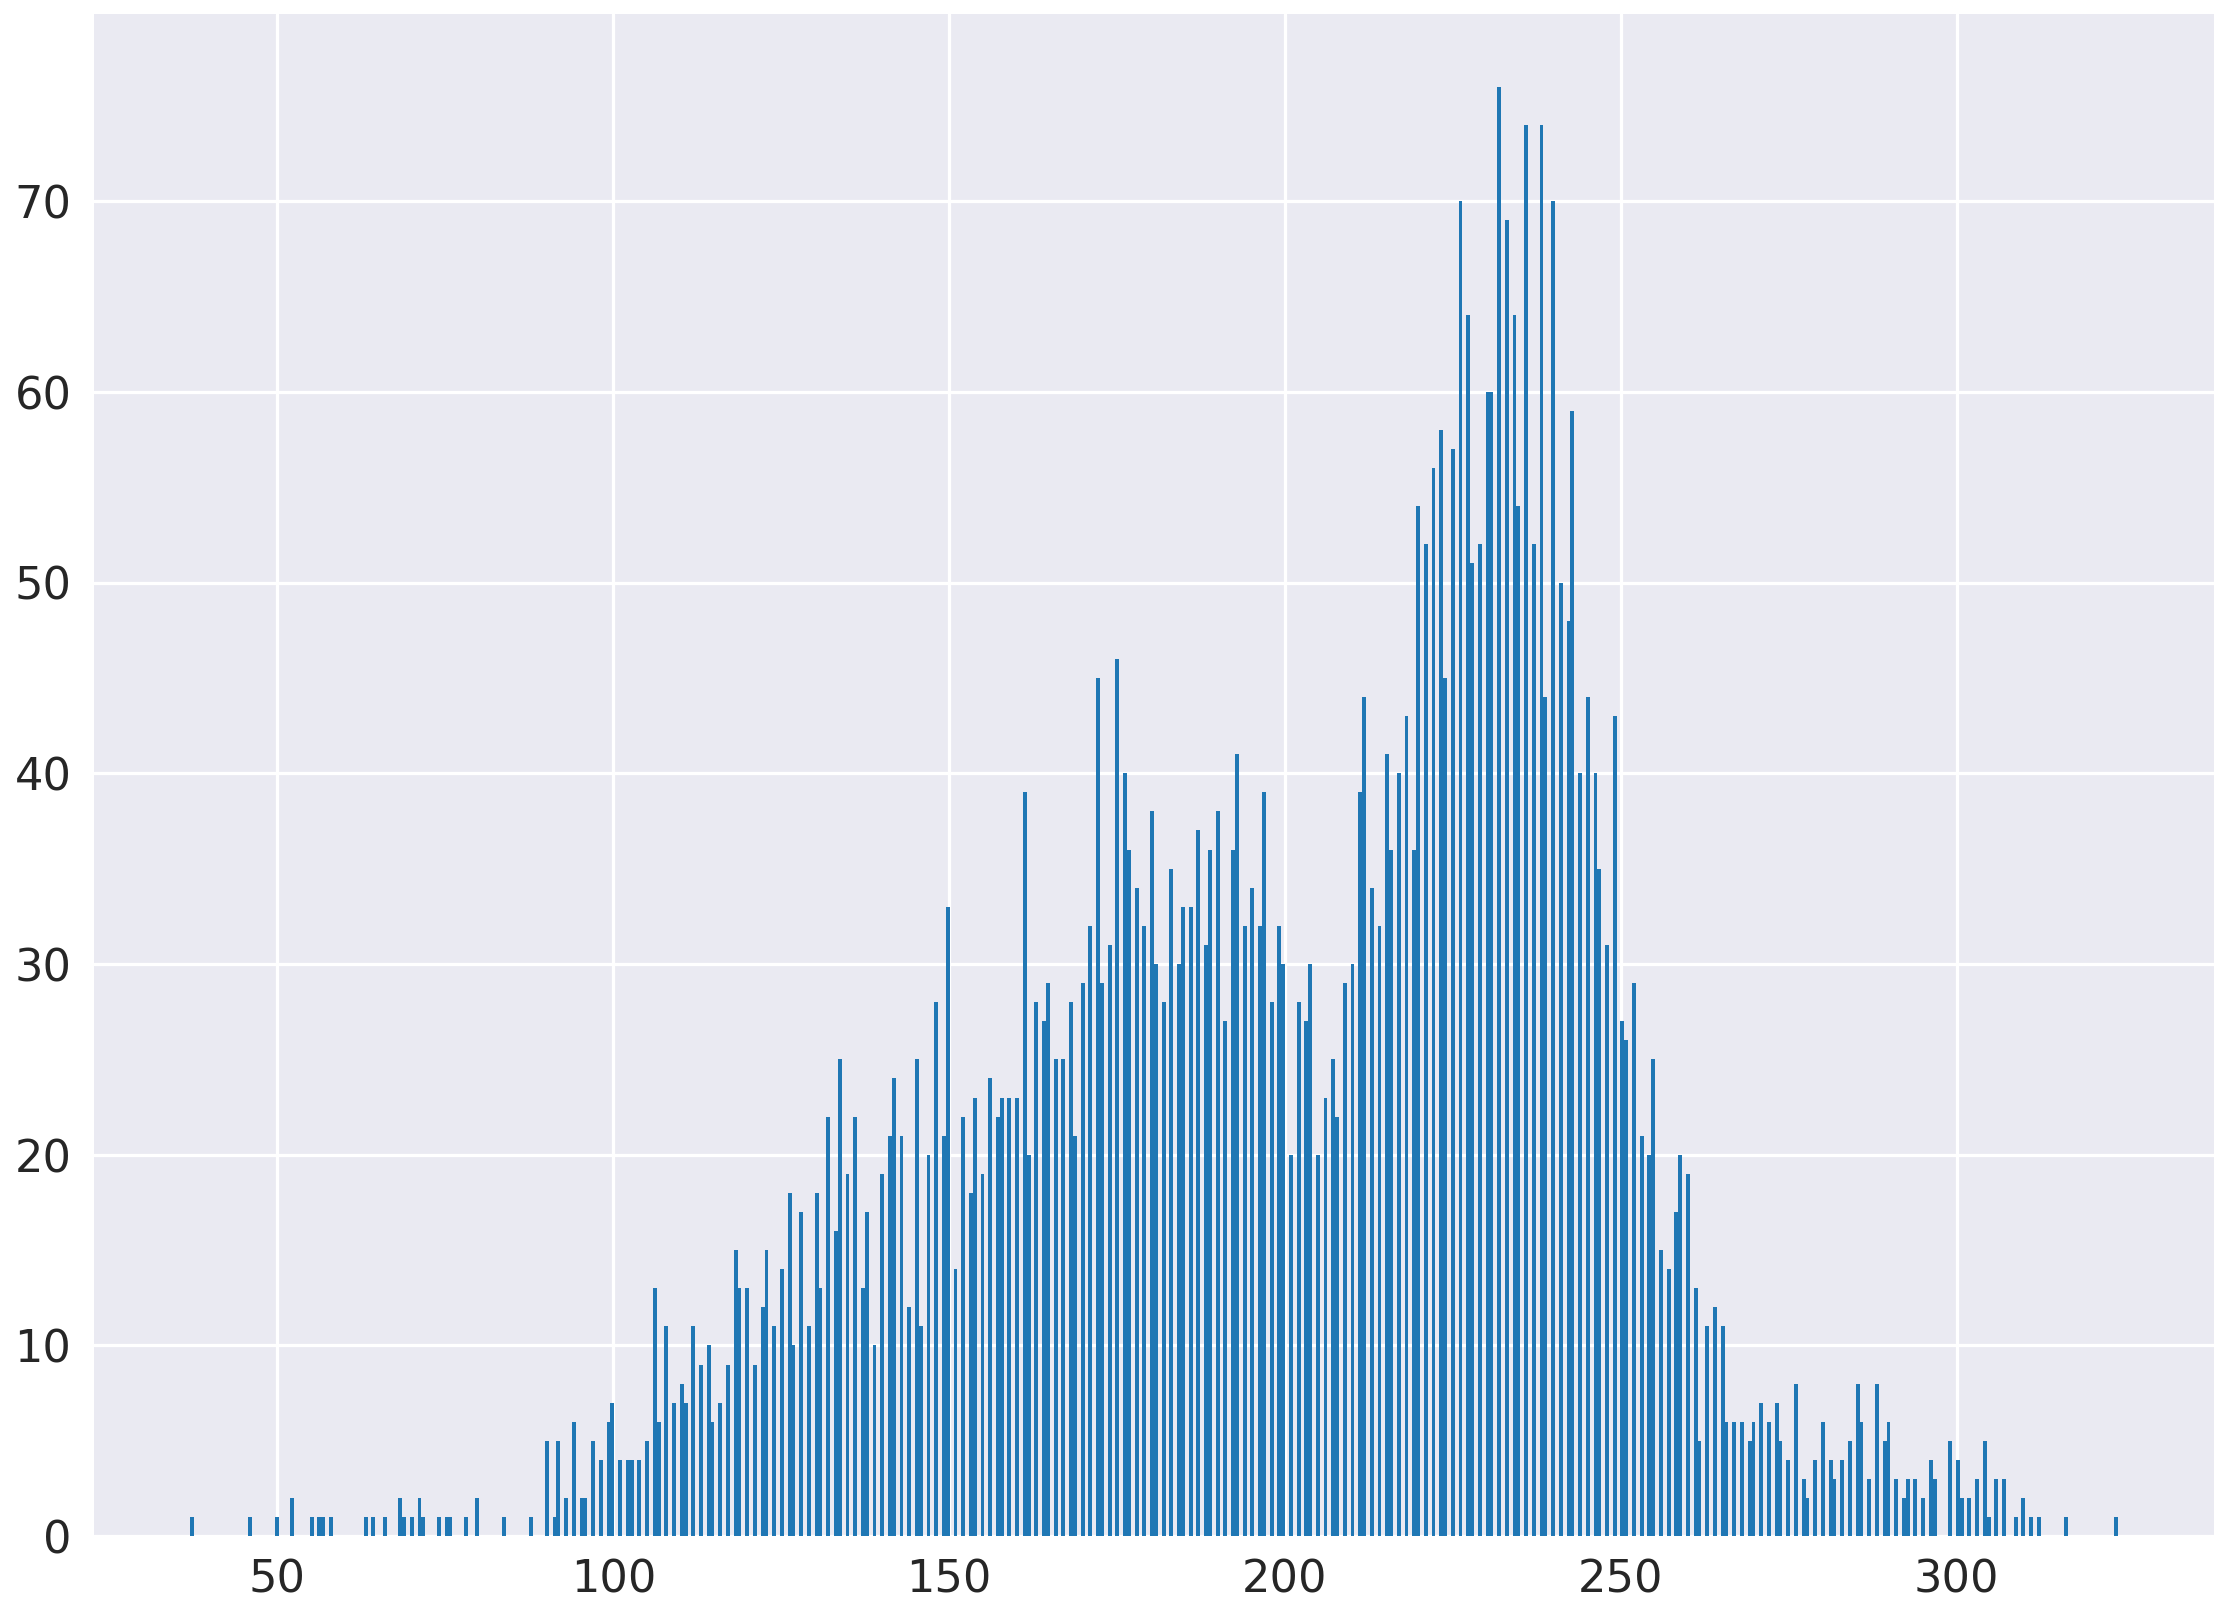

In [98]:
x = np.array(list(countersDict['rolling_10yrs_opsim'].values()))
plt.hist(x[x<400], 500);



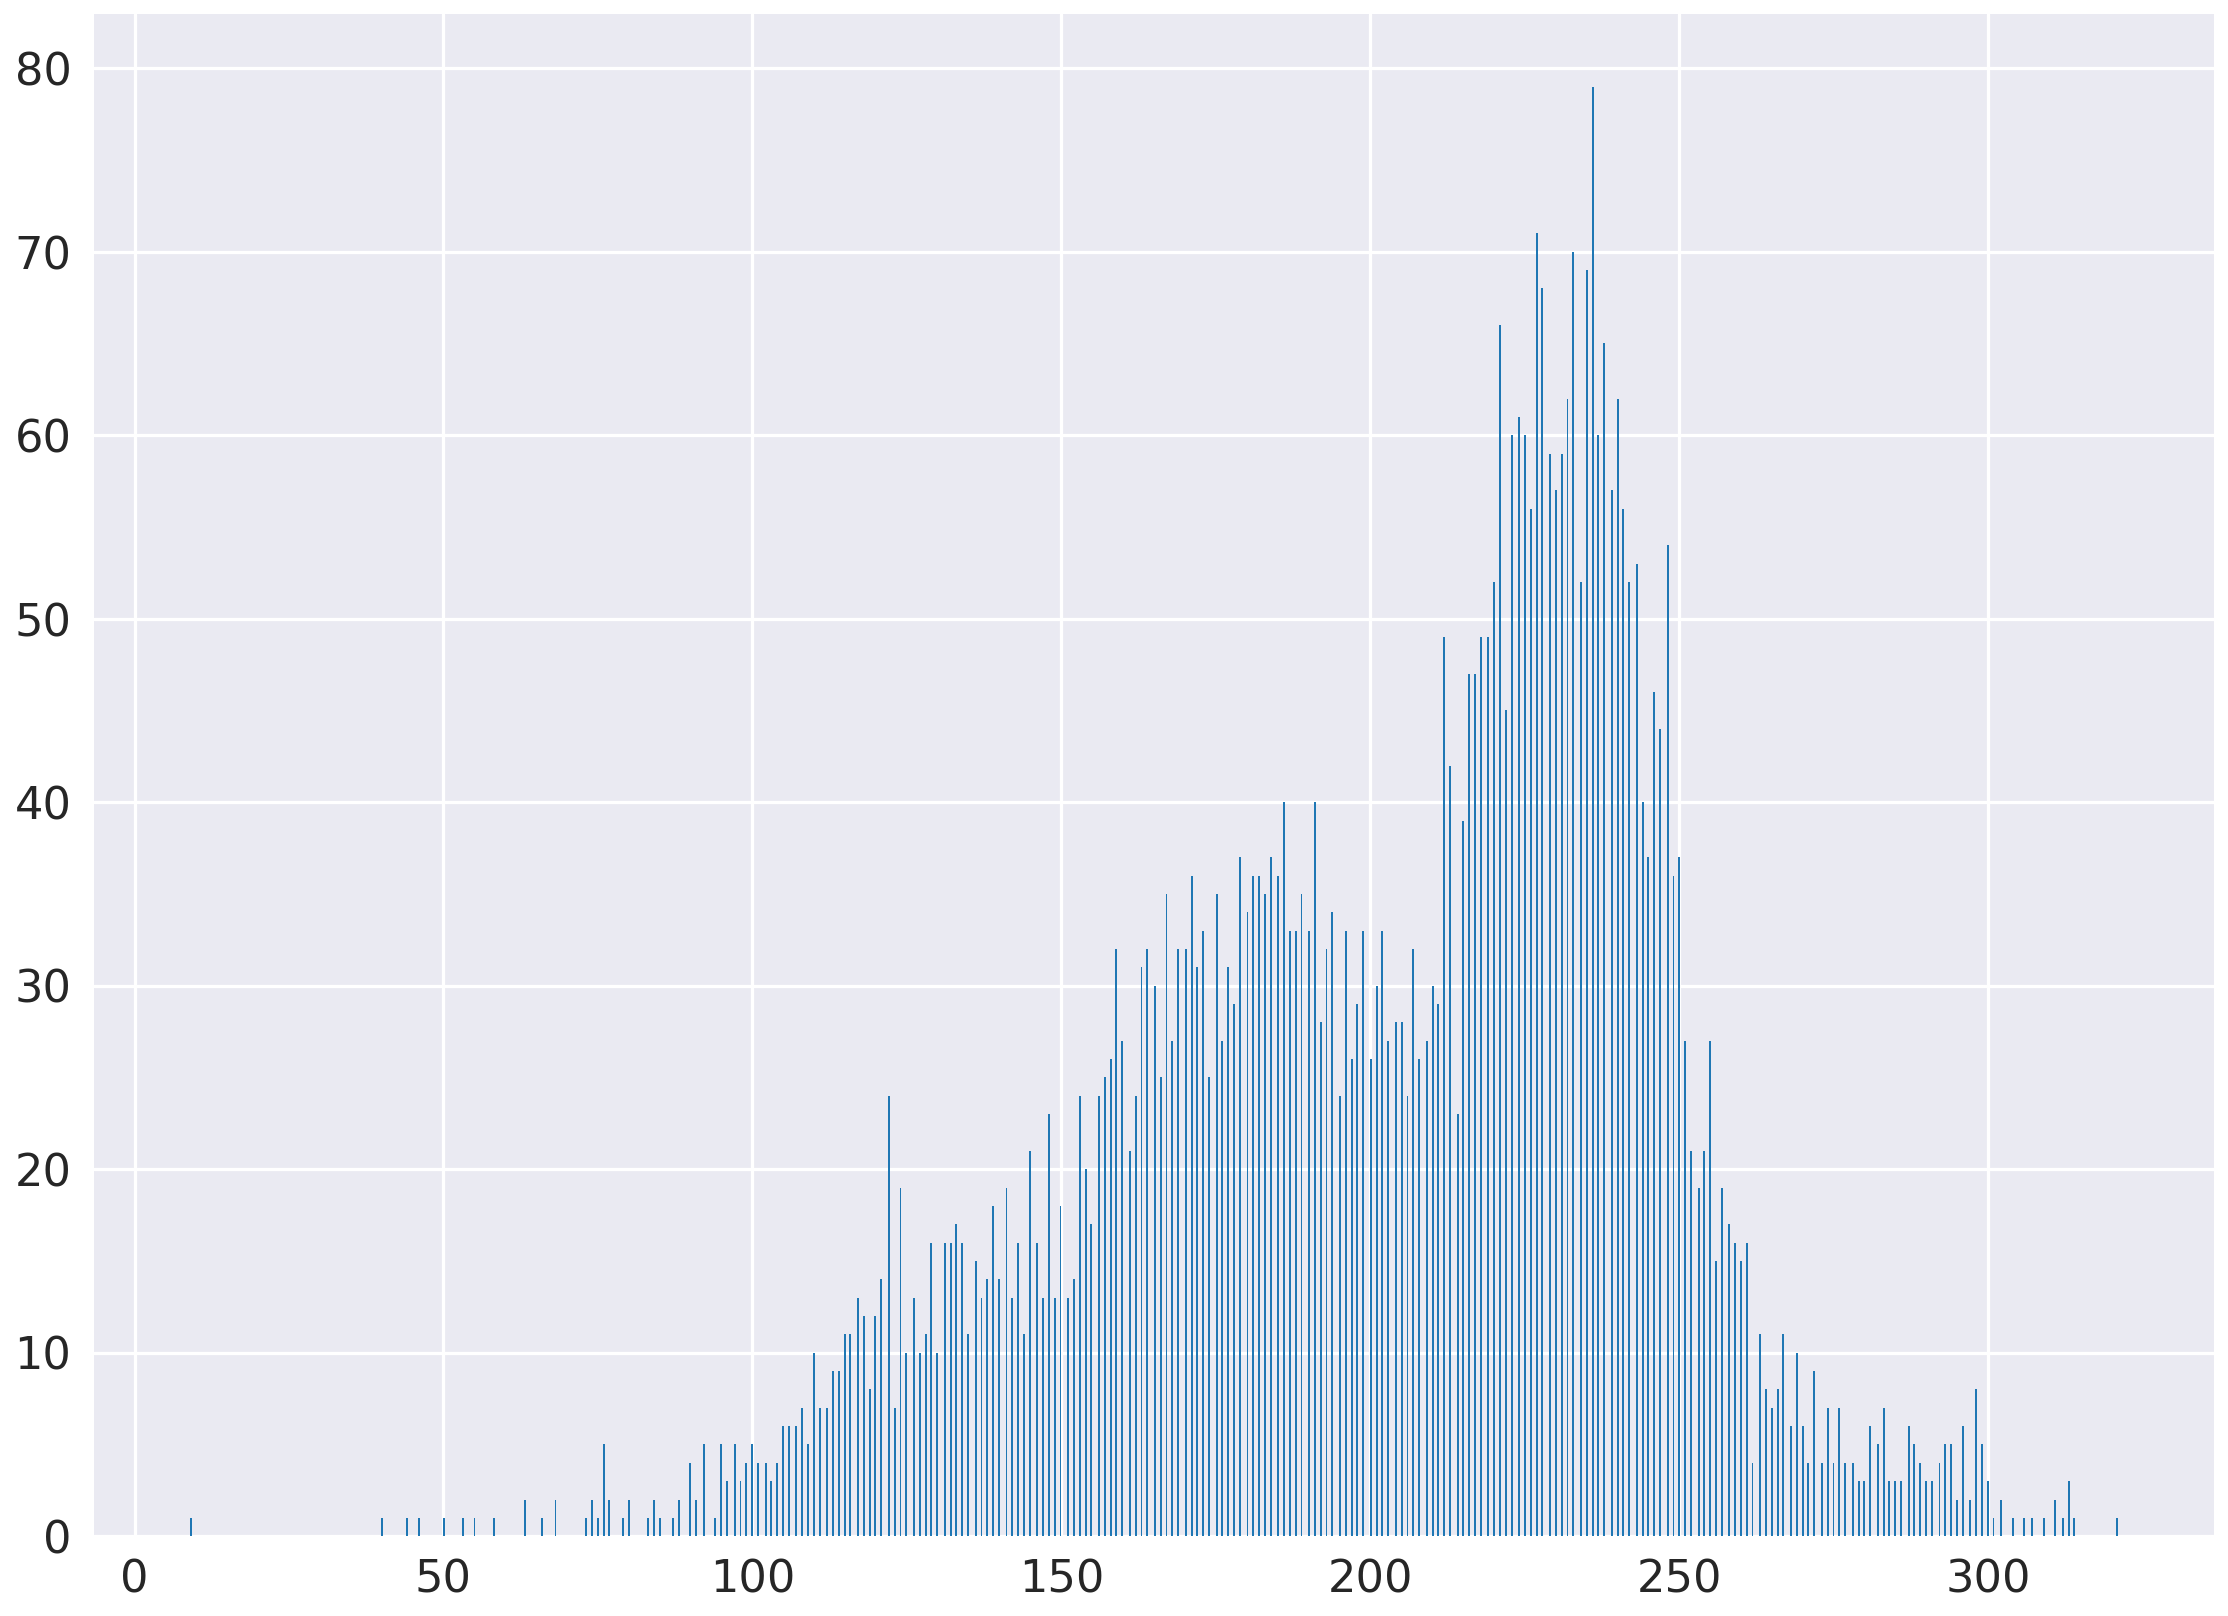

In [73]:
x = np.array(list(countersDict['rolling_10yrs_opsim'].values())
plt.hist(x[x<400], 100);


In [21]:
rolling_pos = list(countersDict['rolling_10yrs_opsim'].keys())

In [15]:
rolling_counts = list(countersDict['rolling_10yrs_opsim'].values())

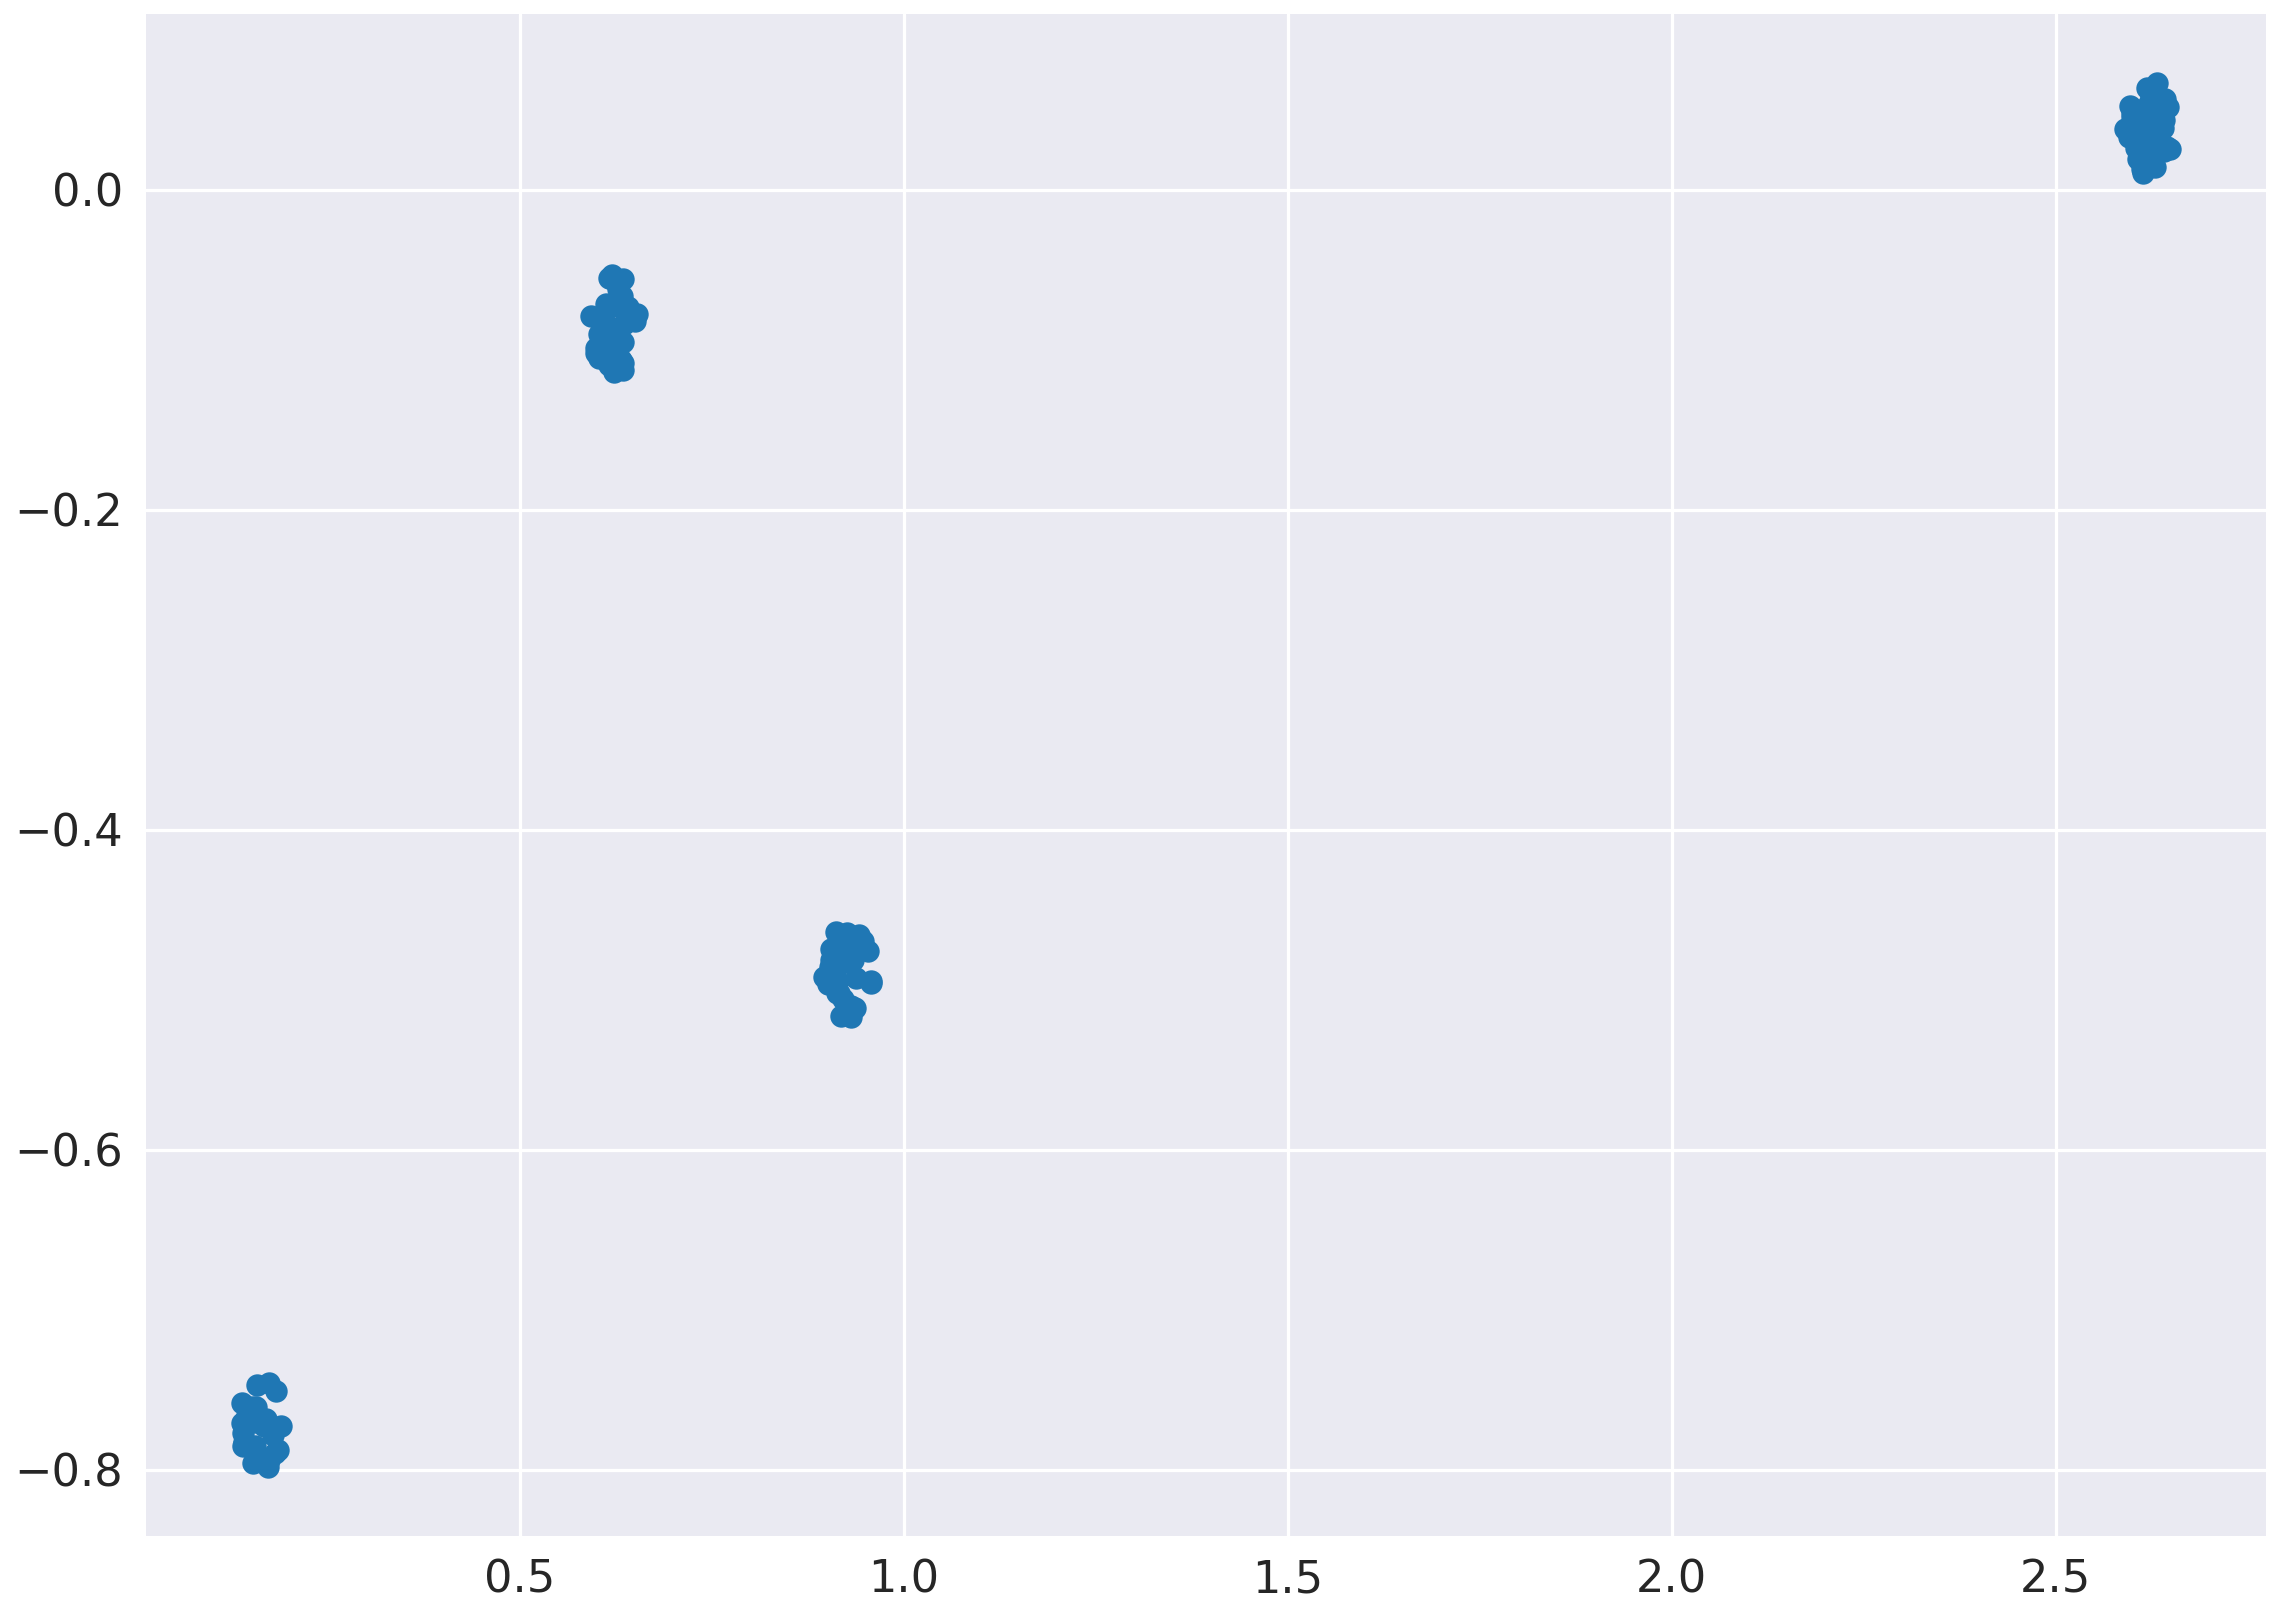

In [32]:
plt.plot([rolling_pos[i][0] for i,rolling_count in enumerate(rolling_counts) if rolling_count>1000], 
         [rolling_pos[i][1] for i,rolling_count in enumerate(rolling_counts) if rolling_count>1000],'o')

In [57]:
import pickle

In [79]:
pickle.dump(countersDict, open('countersDict.p', 'wb'))

In [48]:
countersDict = pickle.load(open('countersDict.p', 'rb'))

In [65]:
np.array([1,2,3])>2

array([False, False,  True])

In [95]:
def returnCounters(model, year, DitherPattern, OpsimRun, rotDithers):
    nightsNum = year*365
    sqlWhere = 'night < '+str(nightsNum)+' and filter = "i"'# and proposalId = '+str(proposalDict[OpsimRun])
    errors_object = ModelErrors(ModelType=model,DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers)
    errors_object.process(sqlWhere)
    return errors_object.counter
for OpsimRun in ['rolling_10yrs_opsim', 'rolling_mix_10yrs_opsim']:
    countersDict[OpsimRun] = returnCounters(model='radial', year=1, DitherPattern='field', OpsimRun=OpsimRun, rotDithers=None)
    

getting the dither positions from the database:  field
using stackers: [None]
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
getting the dither positions from the database:  field
using stackers: [None]
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos


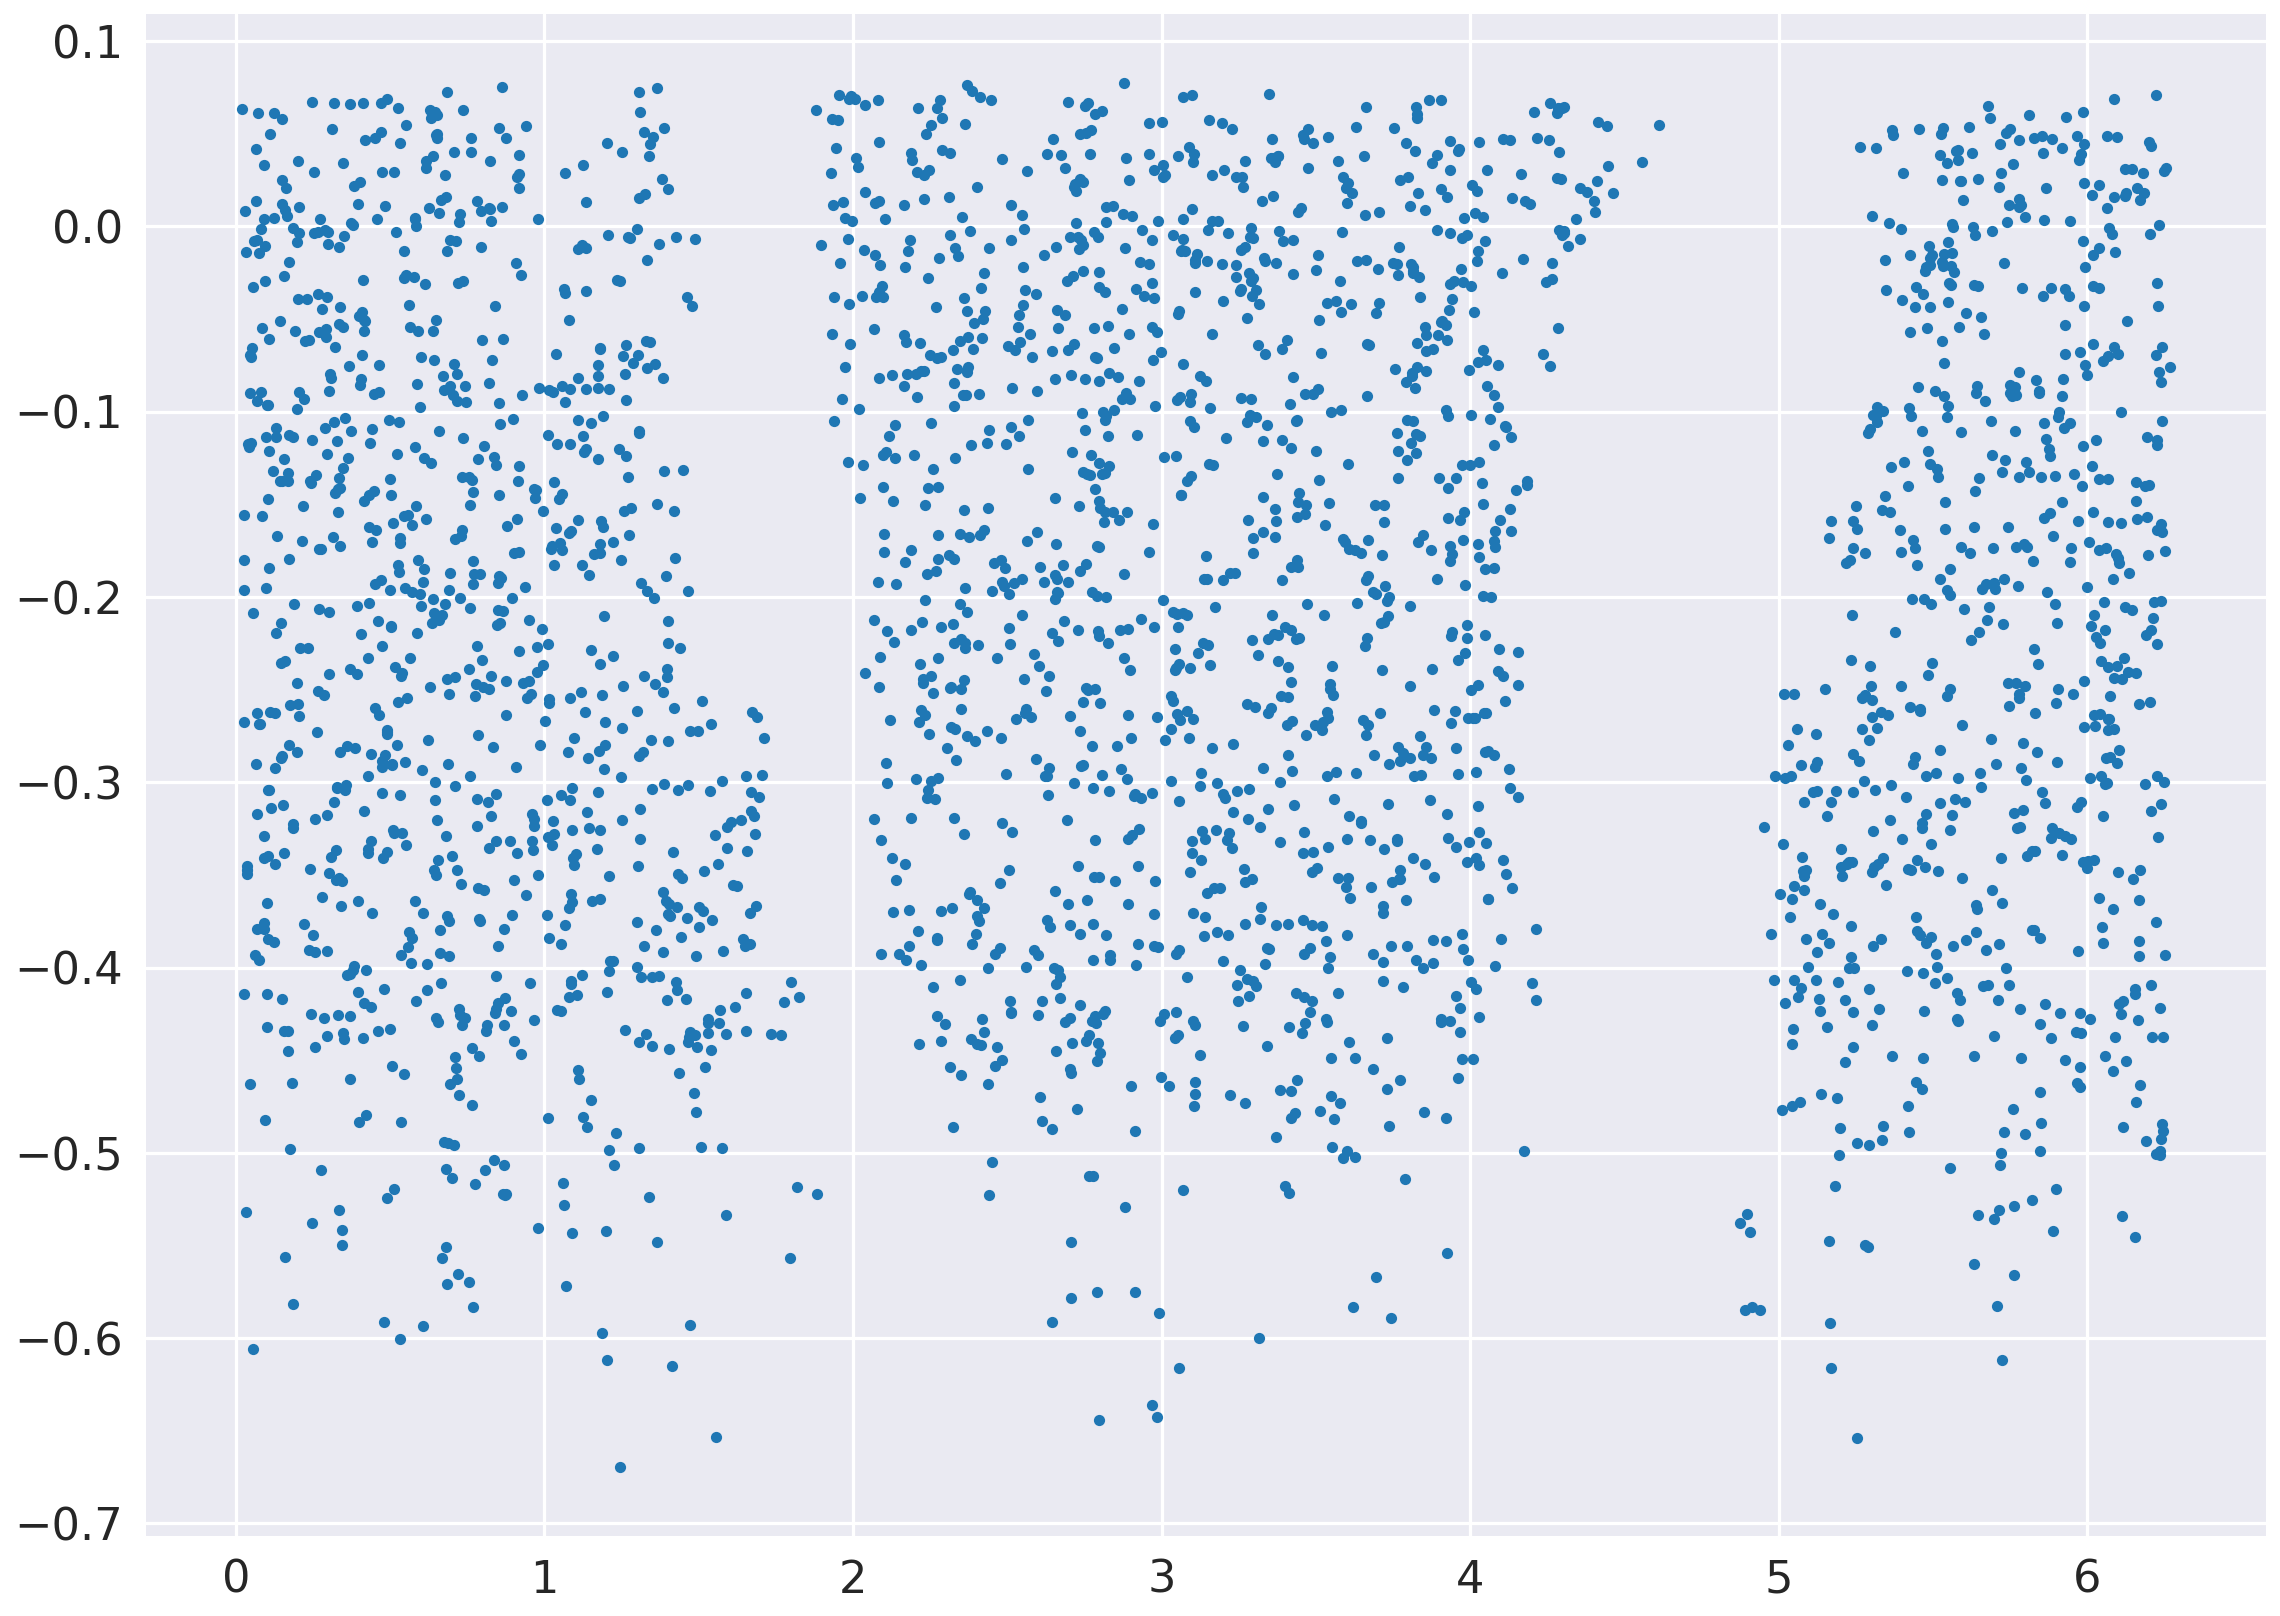

In [82]:
newDict = countersDict['rolling_10yrs_opsim']
plt.plot([pos[0] for pos in newDict.keys() if newDict[pos]>200 ],
         [pos[1] for pos in newDict.keys() if newDict[pos]>200 ],
         '.')
         

Text(0,0.5,'dec')

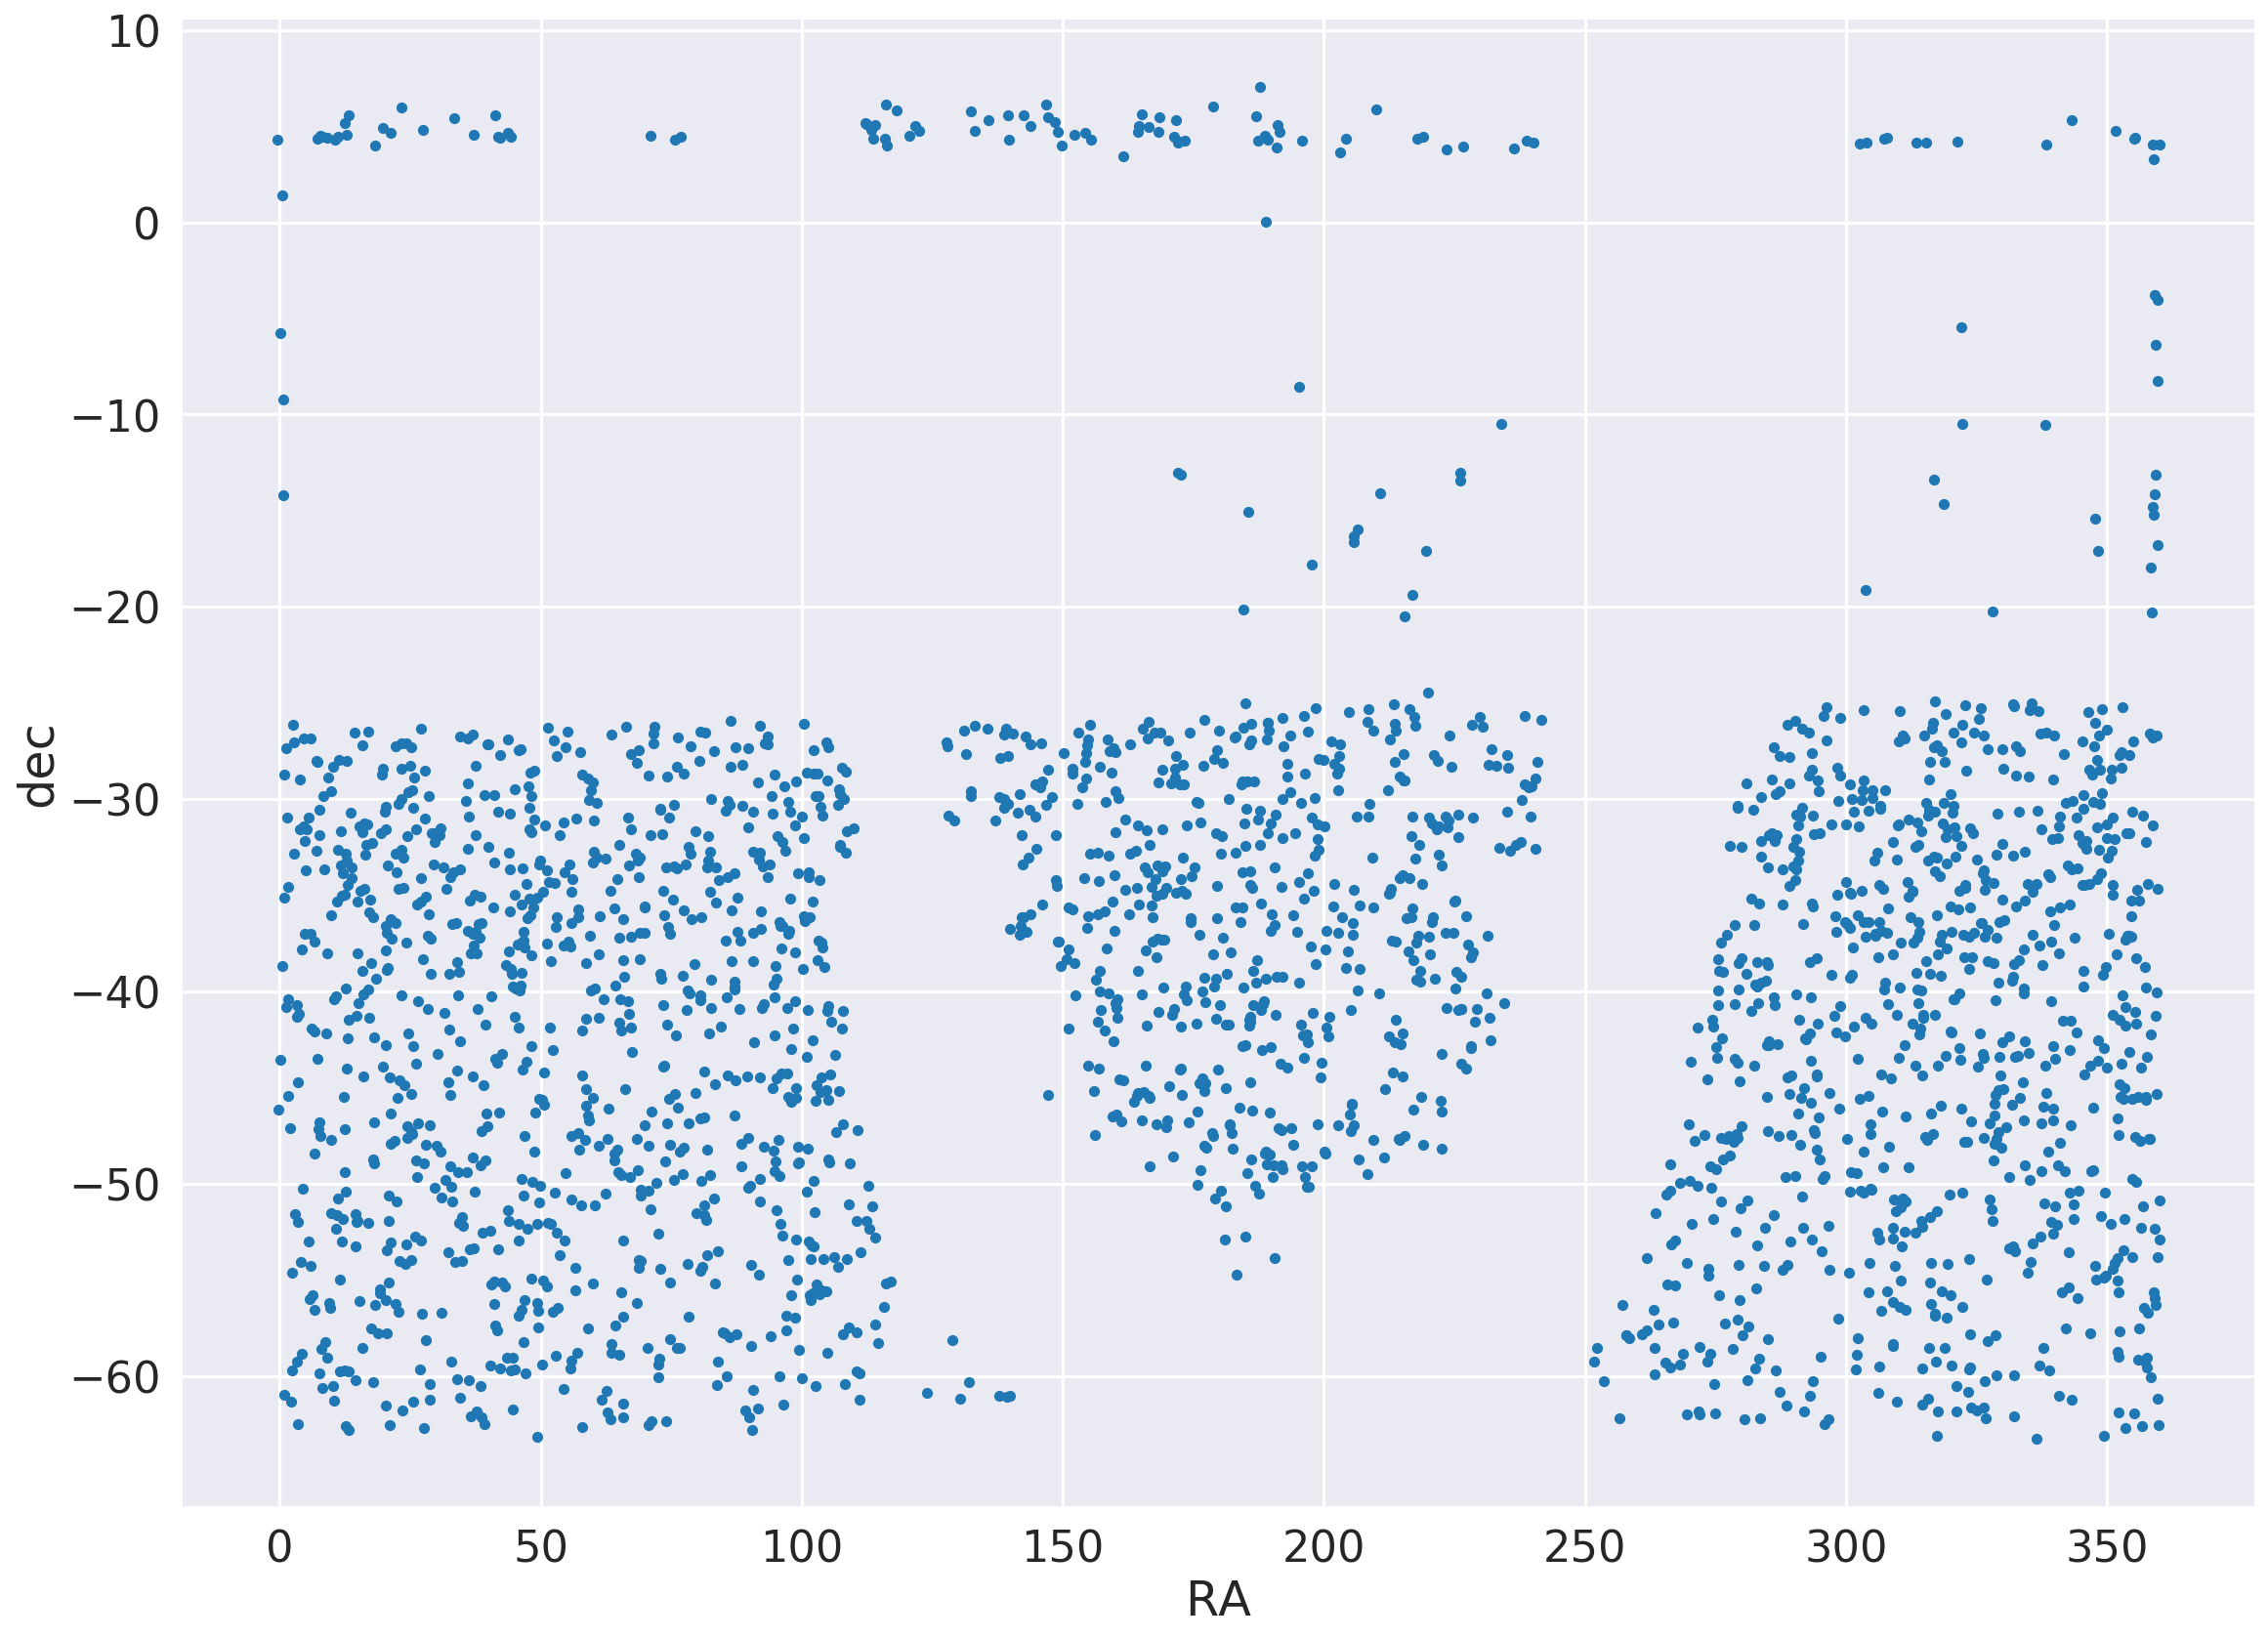

In [87]:
newDict = countersDict['rolling_mix_10yrs_opsim']
plt.plot([pos[0]*np.degrees(1) for pos in newDict.keys() if newDict[pos]<200 ],
         [pos[1]*np.degrees(1) for pos in newDict.keys() if newDict[pos]<200 ],
         '.')
plt.xlabel('RA')
plt.ylabel('dec')

In [31]:
def returnCounters(model, year, DitherPattern, OpsimRun, rotDithers):
    nightsNum = year*365
    sqlWhere = 'night < '+str(nightsNum)+' and filter = "i" and proposalId != '+str(proposalDict[OpsimRun])
    errors_object = ModelErrors(ModelType=model,DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers)
    errors_object.process(sqlWhere)
    return errors_object.counter
for OpsimRun in ['pontus_2502']:
    countersDict[OpsimRun] = returnCounters(model='radial', year=10, DitherPattern='random_visit', OpsimRun=OpsimRun, rotDithers=None)
def returnCounters(model, year, DitherPattern, OpsimRun, rotDithers):
    nightsNum = year*365
    sqlWhere = 'night < '+str(nightsNum)+' and filter = "i" and proposalId = '+str(proposalDict[OpsimRun])
    errors_object = ModelErrors(ModelType=model,DitherPattern=DitherPattern, OpsimRun=OpsimRun, rotDithers=rotDithers)
    errors_object.process(sqlWhere)
    return errors_object.counter
for OpsimRun in list(proposalDict.keys())[:-1]:
    countersDict[OpsimRun] = returnCounters(model='radial', year=10, DitherPattern='random_visit', OpsimRun=OpsimRun, rotDithers=None)

pickle.dump(countersDict, open('countersDict.p', 'wb'))

getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStackers.RandomDitherFieldPerVisitStacker object at 0x2b1b7e464198>]
new sim
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint night < 3650 and filter = "i" and proposalId != 2 for columns ['fieldDec', 'fieldRA']
Found 419949 visits
Running:  ['field dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
getting random rotational dithers
Summary: we are using the OpsimRun at /global/cscratch1/sd/husni/OpsimRuns/pontus_2502, with the translational dither pattern: randomDitherFieldPerVisit. Rotation: None
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStacke

In [10]:
ls /global/cscratch1/sd/husni/OpsimRuns/

alt_sched.db                        kraken_2026.db         mothra_2045.db
baseline2018a.db                    kraken_2026.npy        mothra_2045.npy
baseline2018a.npy                   kraken_2035.db         nexus_2097.db
colossus_2664.db                    kraken_2035.npy        nexus_2097.npy
colossus_2664.npy                   kraken_2036.db         pontus_2002.db
colossus_2665.db                    kraken_2036.npy        pontus_2002.npy
colossus_2665.npy                   kraken_2042.db         pontus_2489.db
colossus_2667.db                    kraken_2042.npy        pontus_2489.npy
colossus_2667.npy                   kraken_2044.db         pontus_2502.db
feature_baseline.npy                kraken_2044.npy        pontus_2502.npy
feature_baseline_update_10yrsv2.db  minion_1012_sqlite.db
feature_baseline_y1.npy             minion_1016_sqlite.db


In [11]:
ls newnpys/

ALT_SchedY1.npy                    kraken_2035spiral_visitY1.npy
ALT_SchedY10.npy                   kraken_2036random_visitY1.npy
baseline2018aY1.npy                kraken_2036random_visitY10.npy
baseline2018aY10.npy               kraken_2042random_visitY1.npy
baseline2018ahex_visitY1.npy       kraken_2042random_visitY10.npy
baseline2018aspiral_visitY1.npy    kraken_2044random_visitY1.npy
colossus_2664Y1.npy                kraken_2044random_visitY10.npy
colossus_2664Y10.npy               mothra_2045Y1.npy
colossus_2664hex_visitY1.npy       mothra_2045Y10.npy
colossus_2664spiral_visitY1.npy    mothra_2045hex_visitY1.npy
colossus_2665Y1.npy                mothra_2045spiral_visitY1.npy
colossus_2665Y10.npy               nexus_2097random_visitY1.npy
colossus_2665hex_visitY1.npy       nexus_2097random_visitY10.npy
colossus_2665spiral_visitY1.npy    pontus_2002Y1.npy
colossus_2667Y1.npy                pontus_2002Y10.npy
colossus_2667Y10.npy               pontus_2002hex_visitY1.npy
colossus_2

In [7]:
runs = list(proposalDict.keys())

In [9]:
runs[:-1]

['baseline2018a',
 'colossus_2664',
 'colossus_2665',
 'colossus_2667',
 'kraken_2026',
 'kraken_2035',
 'kraken_2036',
 'kraken_2042',
 'kraken_2044',
 'mothra_2045',
 'nexus_2097',
 'pontus_2002',
 'pontus_2489']

In [9]:
for year in [1,3,6,10]:
    getDeltaXips(n=1, model='radial', year=year, DitherPattern='random_visit', OpsimRun='pontus_2502', rotDithers=None)

pontus_2502
getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStackers.RandomDitherFieldPerVisitStacker object at 0x2af151de0d30>]
new sim
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint night < 365 and filter = "i" and proposalId != 2 for columns ['fieldRA', 'fieldDec']
Found 32351 visits
Running:  ['field dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
getting random rotational dithers
Summary: we are using the OpsimRun at /global/cscratch1/sd/husni/OpsimRuns/pontus_2502, with the translational dither pattern: randomDitherFieldPerVisit. Rotation: None
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
there are now 24 runs total for this strategy
pontus_2502
getting the dither positions from the database:  randomDithe

In [10]:
%%time
for OpsimRun in runs[:-1]:
    getDeltaXips(n=1, model='radial', year=10, DitherPattern='random_visit', OpsimRun=OpsimRun, rotDithers=None)

baseline2018a
getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStackers.RandomDitherFieldPerVisitStacker object at 0x2ac03e69d2b0>]
new sim
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint night < 3650 and filter = "i" and proposalId = 3 for columns ['fieldDec', 'fieldRA']
Found 444867 visits
Running:  ['field dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
getting random rotational dithers
Summary: we are using the OpsimRun at /global/cscratch1/sd/husni/OpsimRuns/baseline2018a, with the translational dither pattern: randomDitherFieldPerVisit. Rotation: None
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
there are now 24 runs total for this strategy
colossus_2664
getting the dither positions from the database:  rand

In [130]:
random_y1_delta_xips = np.load('newnpys/random_y1_delta_xips.npy')[0]
random_y10_delta_xips = np.load('newnpys/random_y10_delta_xips.npy')[0]
alt_y1_delta_xips = np.load('newnpys/ALT_SchedY1.npy')[-1]
alt_y10_delta_xips = np.load('newnpys/ALT_SchedY10.npy')[-1]
fb_y10_delta_xips = np.load('newnpys/fb_y10_delta_xips.npy')[-1]
fb_y1_delta_xips = np.load('newnpys/feature_baselineY1.npy')[-1]
r = np.load('npys/r.npy')

In [116]:
baseline2018aY1 = np.load('newnpys/baseline2018aY1.npy')
kraken_2026Y1 = np.load('newnpys/kraken_2026Y1.npy')
kraken_2035Y1 = np.load('newnpys/kraken_2035Y1.npy')
pontus_2002Y1 = np.load('newnpys/pontus_2002Y1.npy')
pontus_2489Y1 = np.load('newnpys/pontus_2489Y1.npy')
colossus_2664Y1 = np.load('newnpys/colossus_2664Y1.npy')
colossus_2665Y1 = np.load('newnpys/colossus_2665Y1.npy')
colossus_2667Y1 = np.load('newnpys/colossus_2667Y1.npy')
mothra_2045Y1 = np.load('newnpys/mothra_2045Y1.npy')

In [117]:
baseline2018aY10 = np.load('newnpys/baseline2018aY10.npy')
kraken_2026Y10 = np.load('newnpys/kraken_2026Y10.npy')
kraken_2035Y10 = np.load('newnpys/kraken_2035Y10.npy')
pontus_2002Y10 = np.load('newnpys/pontus_2002Y10.npy')
pontus_2489Y10 = np.load('newnpys/pontus_2489Y10.npy')
colossus_2664Y10 = np.load('newnpys/colossus_2664Y10.npy')
colossus_2665Y10 = np.load('newnpys/colossus_2665Y10.npy')
colossus_2667Y10 = np.load('newnpys/colossus_2667Y10.npy')
mothra_2045Y10 = np.load('newnpys/mothra_2045Y10.npy')

some exploratory plots

In [10]:
%%time
FeatureBaselineY1 = ModelErrors('radial', DitherPattern='field', rotDithers=None, OpsimRun='feature_baseline_update_10yrsv2')
FeatureBaselineY1.process(sqlWhere='filter = "r" and night < 365 and survey_id = 1')


moving back from moment space to elipticities
finding rhos
CPU times: user 33min 24s, sys: 2.91 s, total: 33min 27s
Wall time: 33min 27s


(-60, 10)

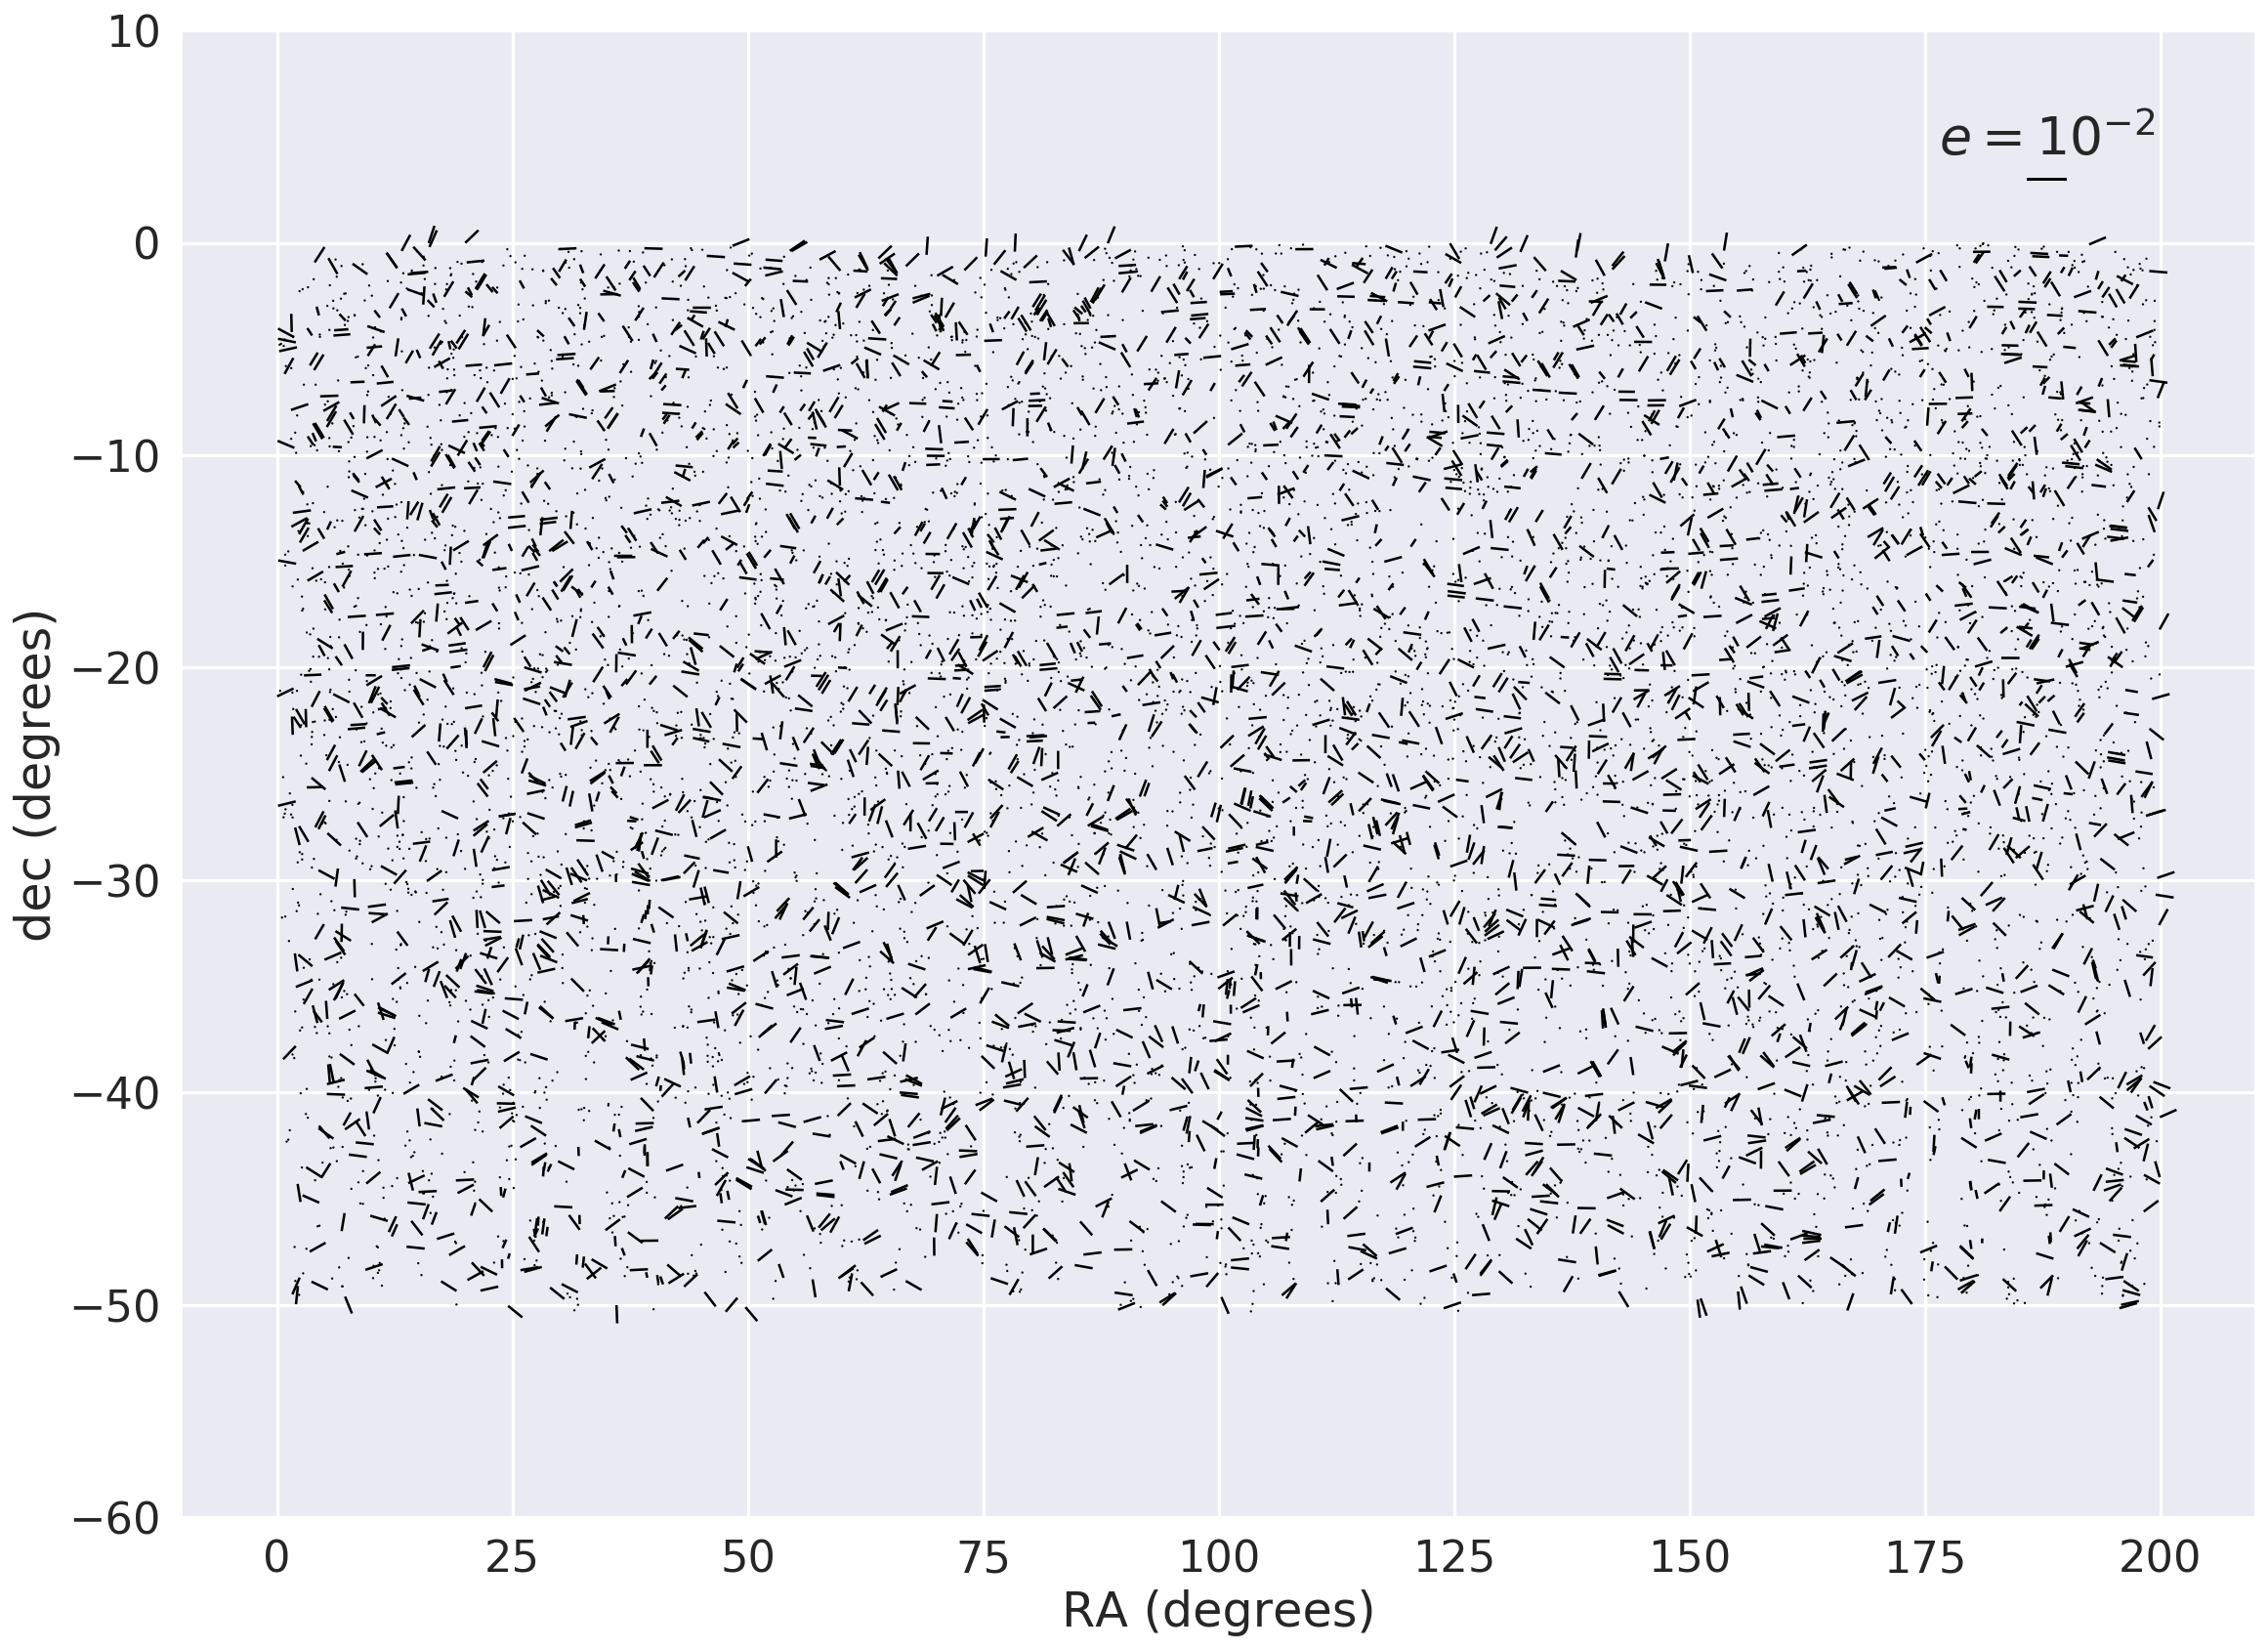

In [189]:
obj = FeatureBaselineY10.DELTA
X = np.array(list(obj.e.keys()))[:,0]
Y = np.array(list(obj.e.keys()))[:,1]
e1 = np.array(list(obj.e.values()))[:,0]
e2 = np.array(list(obj.e.values()))[:,1]
lengths = np.sqrt(e1**2+e2**2)
angles = np.array([r2d(0.5*np.arctan2(ei2,ei1)) for ei1,ei2 in zip(e1,e2)])
pixel_scale = r2d(1)
U = lengths*np.cos(angles)
V = lengths*np.sin(angles)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,units='dots');
plt.quiverkey(Q, 0.9, 0.9, 0.01, label=r'$ e = 10^{-2}$', angle=0)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
plt.ylim((-60, 10))



(-60, 10)

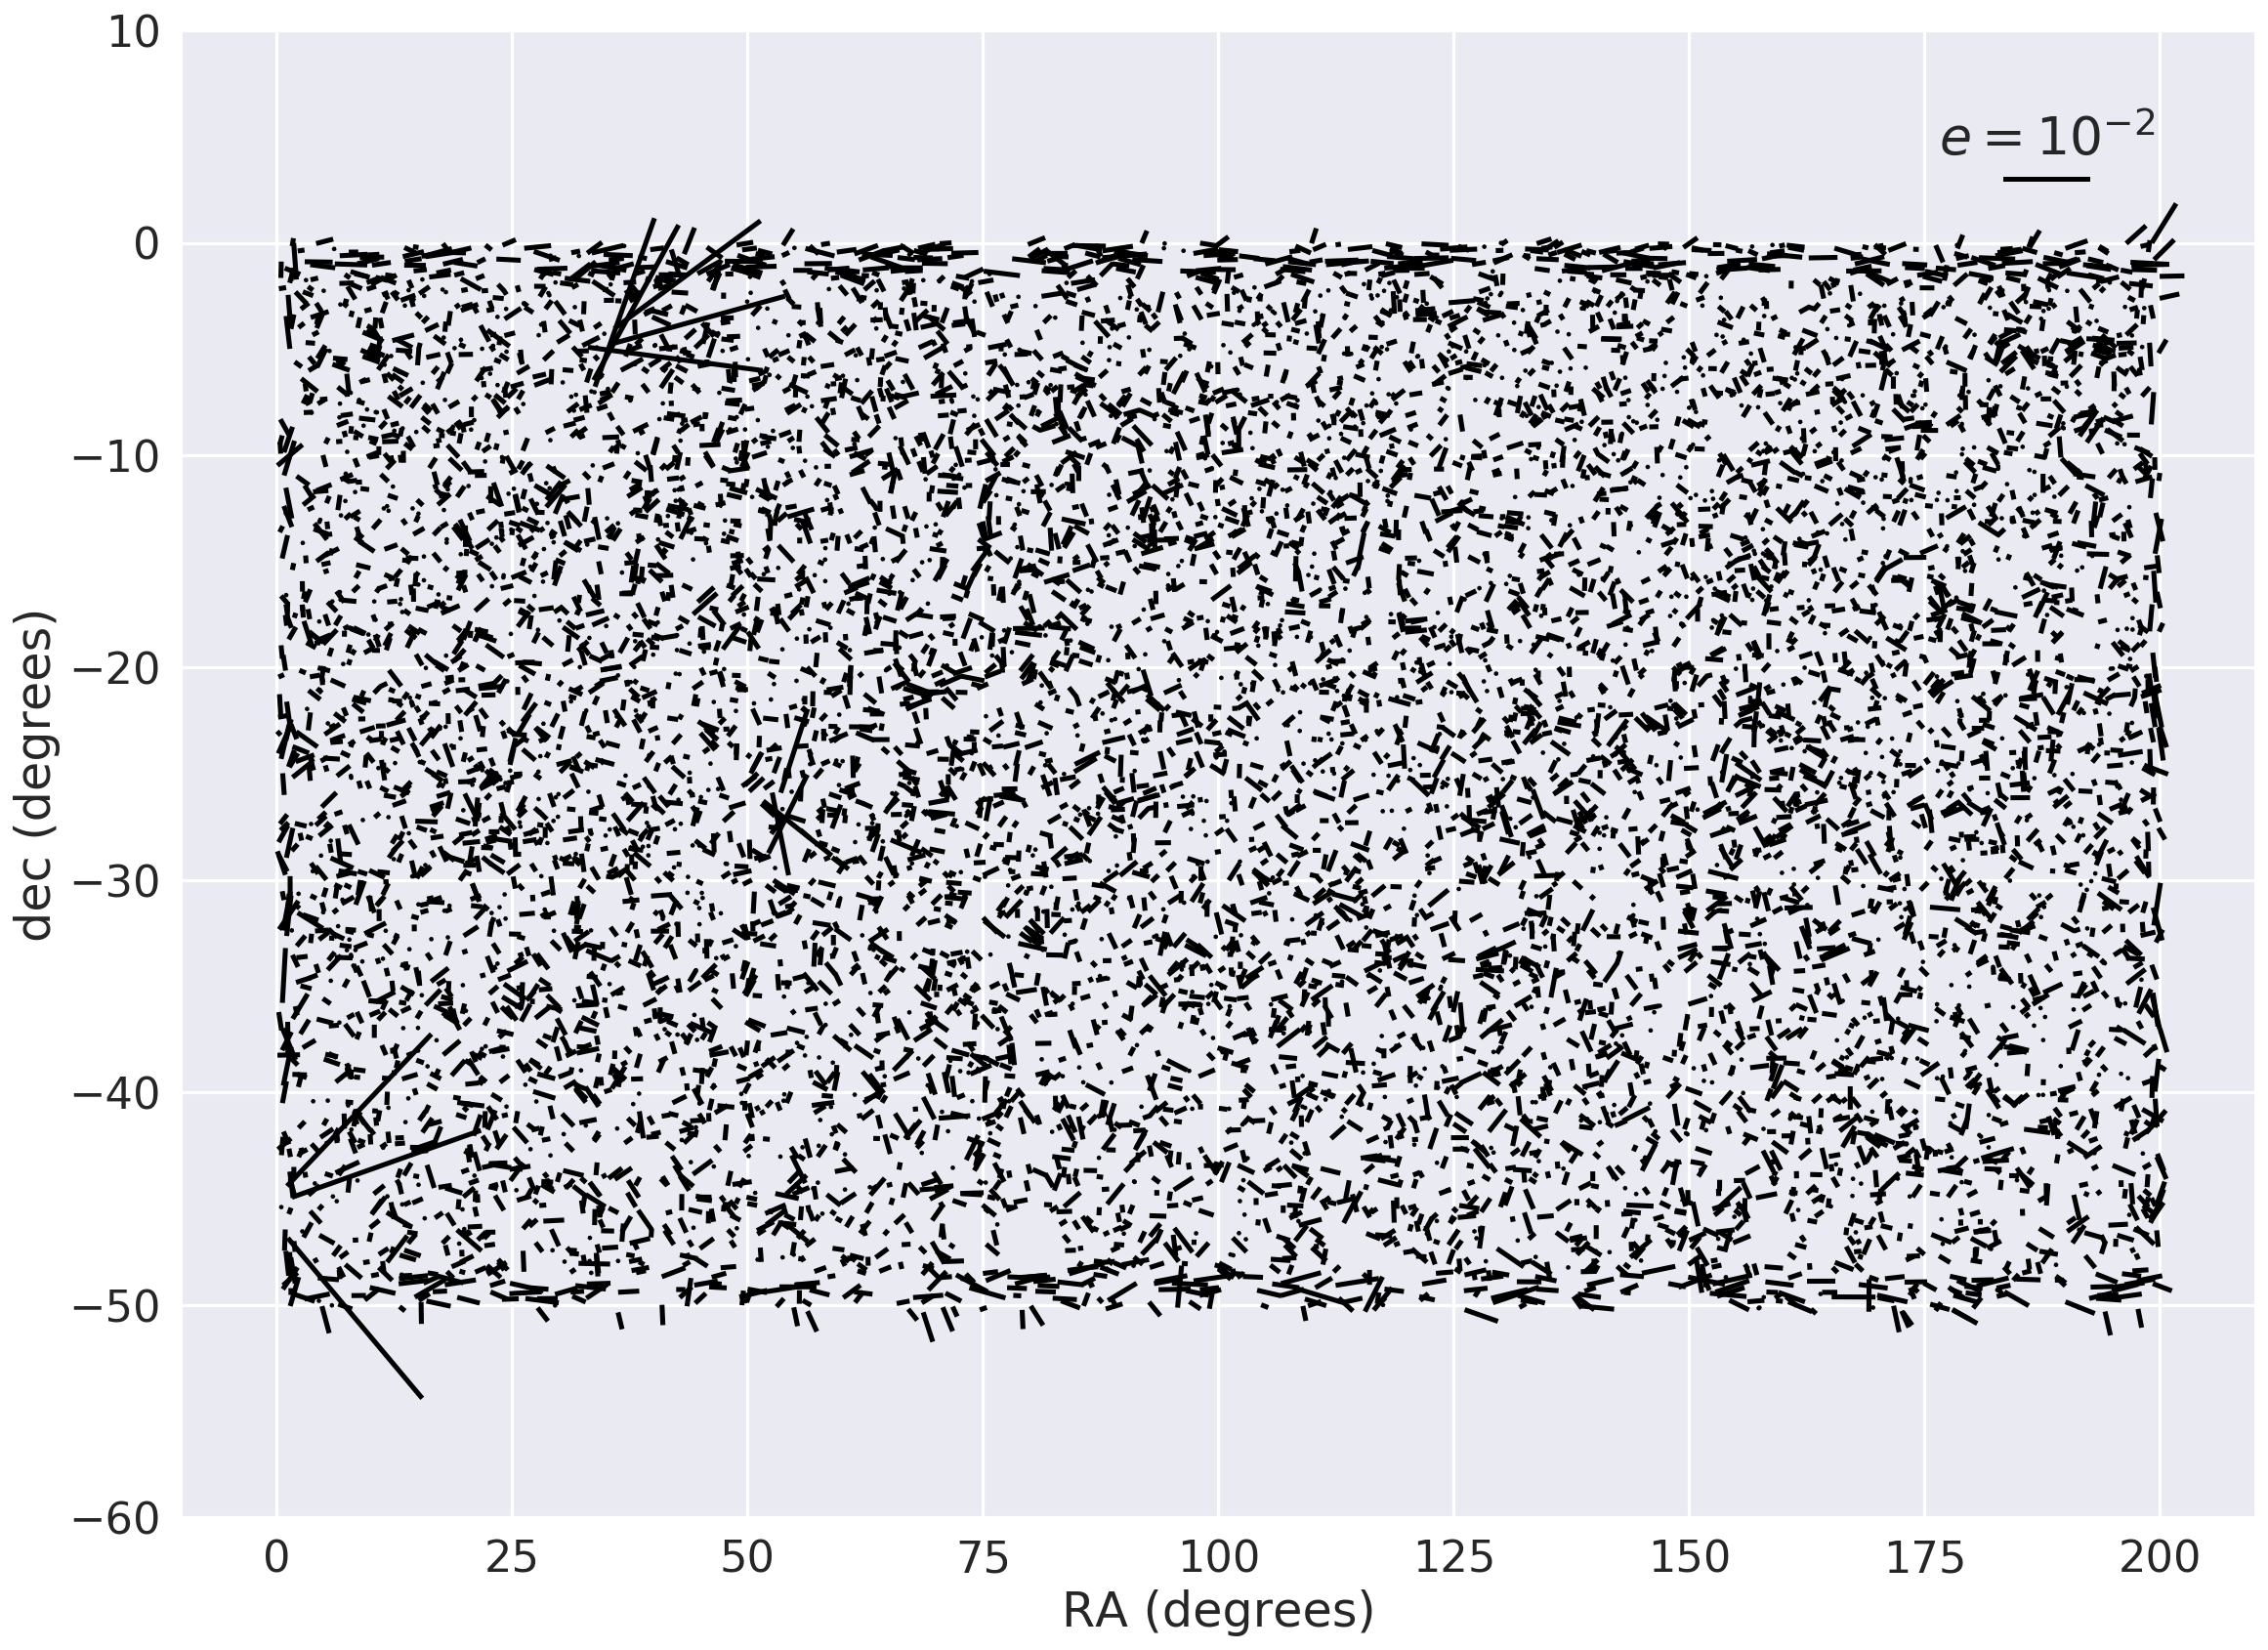

In [47]:
obj = ALT_SchedY10.STAR
X = np.array(list(obj.e.keys()))[:,0]
Y = np.array(list(obj.e.keys()))[:,1]
e1 = np.array(list(obj.e.values()))[:,0]
e2 = np.array(list(obj.e.values()))[:,1]
lengths = np.sqrt(e1**2+e2**2)
angles = np.array([r2d(0.5*np.arctan2(ei2,ei1)) for ei1,ei2 in zip(e1,e2)])
pixel_scale = r2d(1)
U = lengths*np.cos(angles)
V = lengths*np.sin(angles)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,units='height');
plt.quiverkey(Q, 0.9, 0.9, 0.01/0.413204507083531, label=r'$ e = 10^{-2}$', angle=0)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
plt.ylim((-60, 10))


### Hexagonal Dithers at Y10
Using hexDithersPerVisit. 

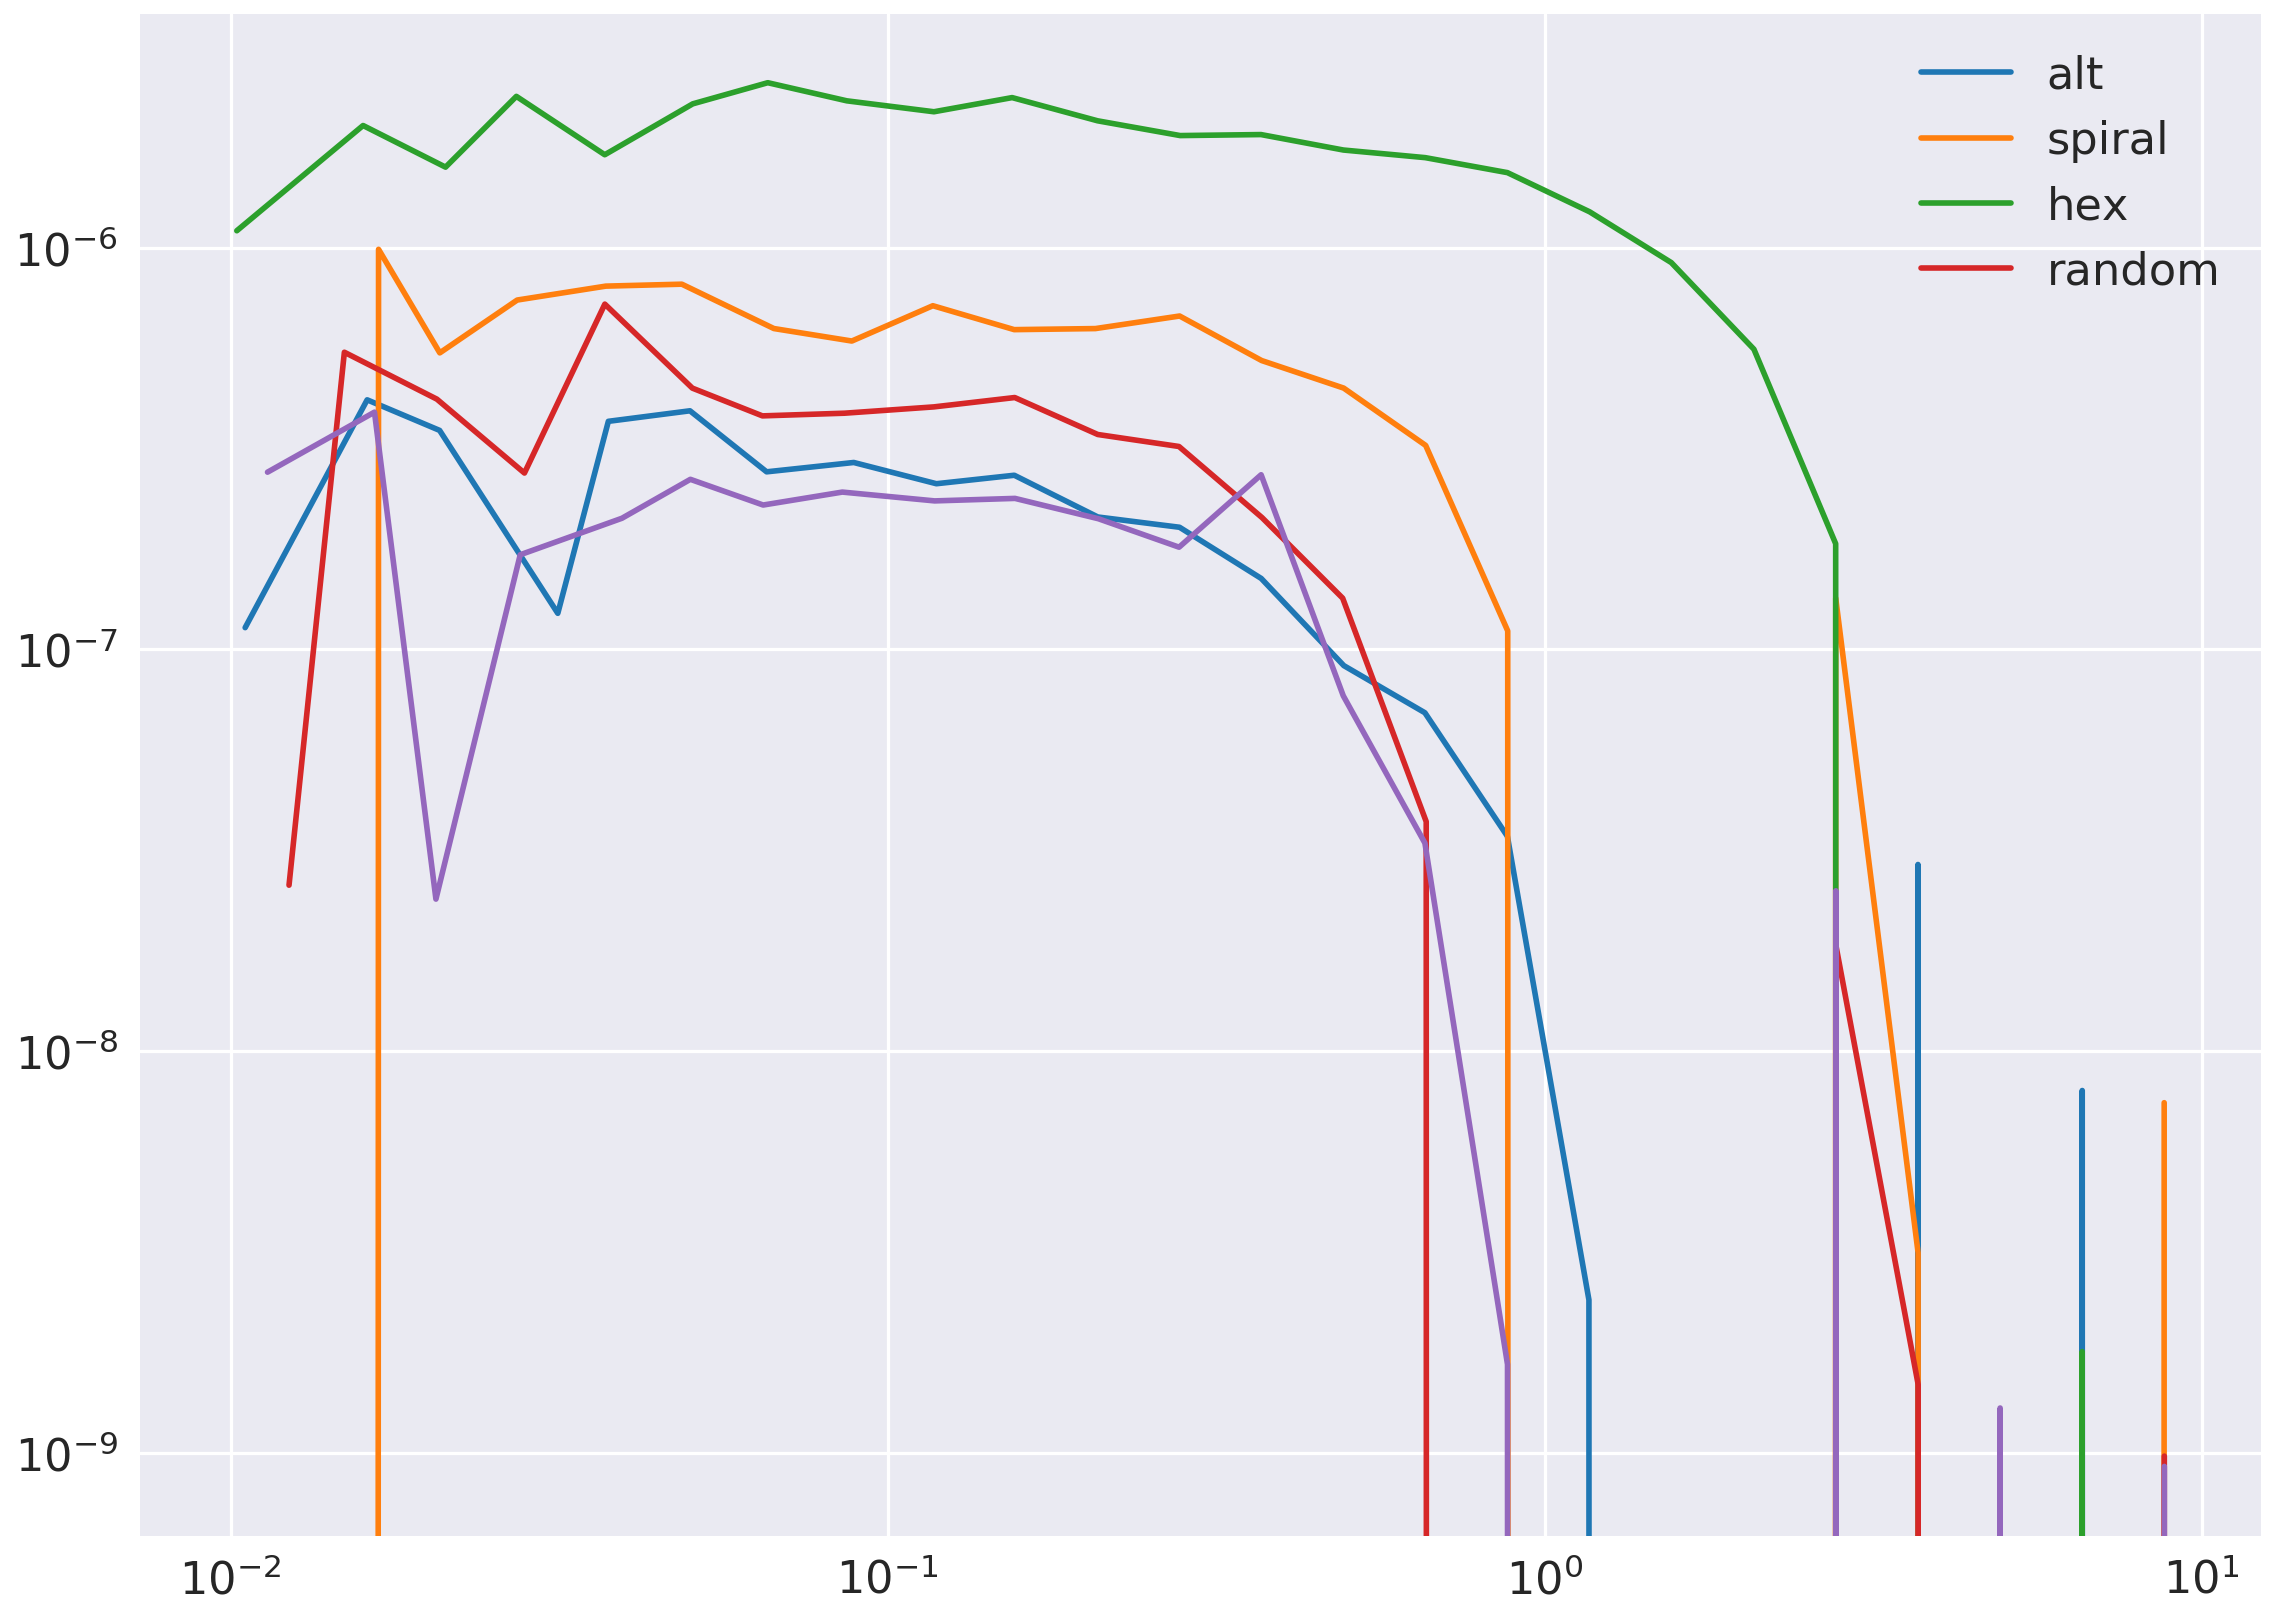

In [52]:
plt.loglog(ALT_SchedY10.r, ALT_SchedY10.delta_xip,label='alt')
plt.loglog(SpiralVisitY10.r, SpiralVisitY10.delta_xip, label='spiral')
plt.loglog(HexRotVisitHorizontalY10.r, HexRotVisitHorizontalY10.delta_xip, label='hex')
plt.loglog(RandomVisitY10.r, RandomVisitY10.delta_xip, label='random')
plt.loglog(FeatureBaselineY10.r, FeatureBaselineY10.delta_xip)
plt.legend()

#### KS Test for HexVisitY10:

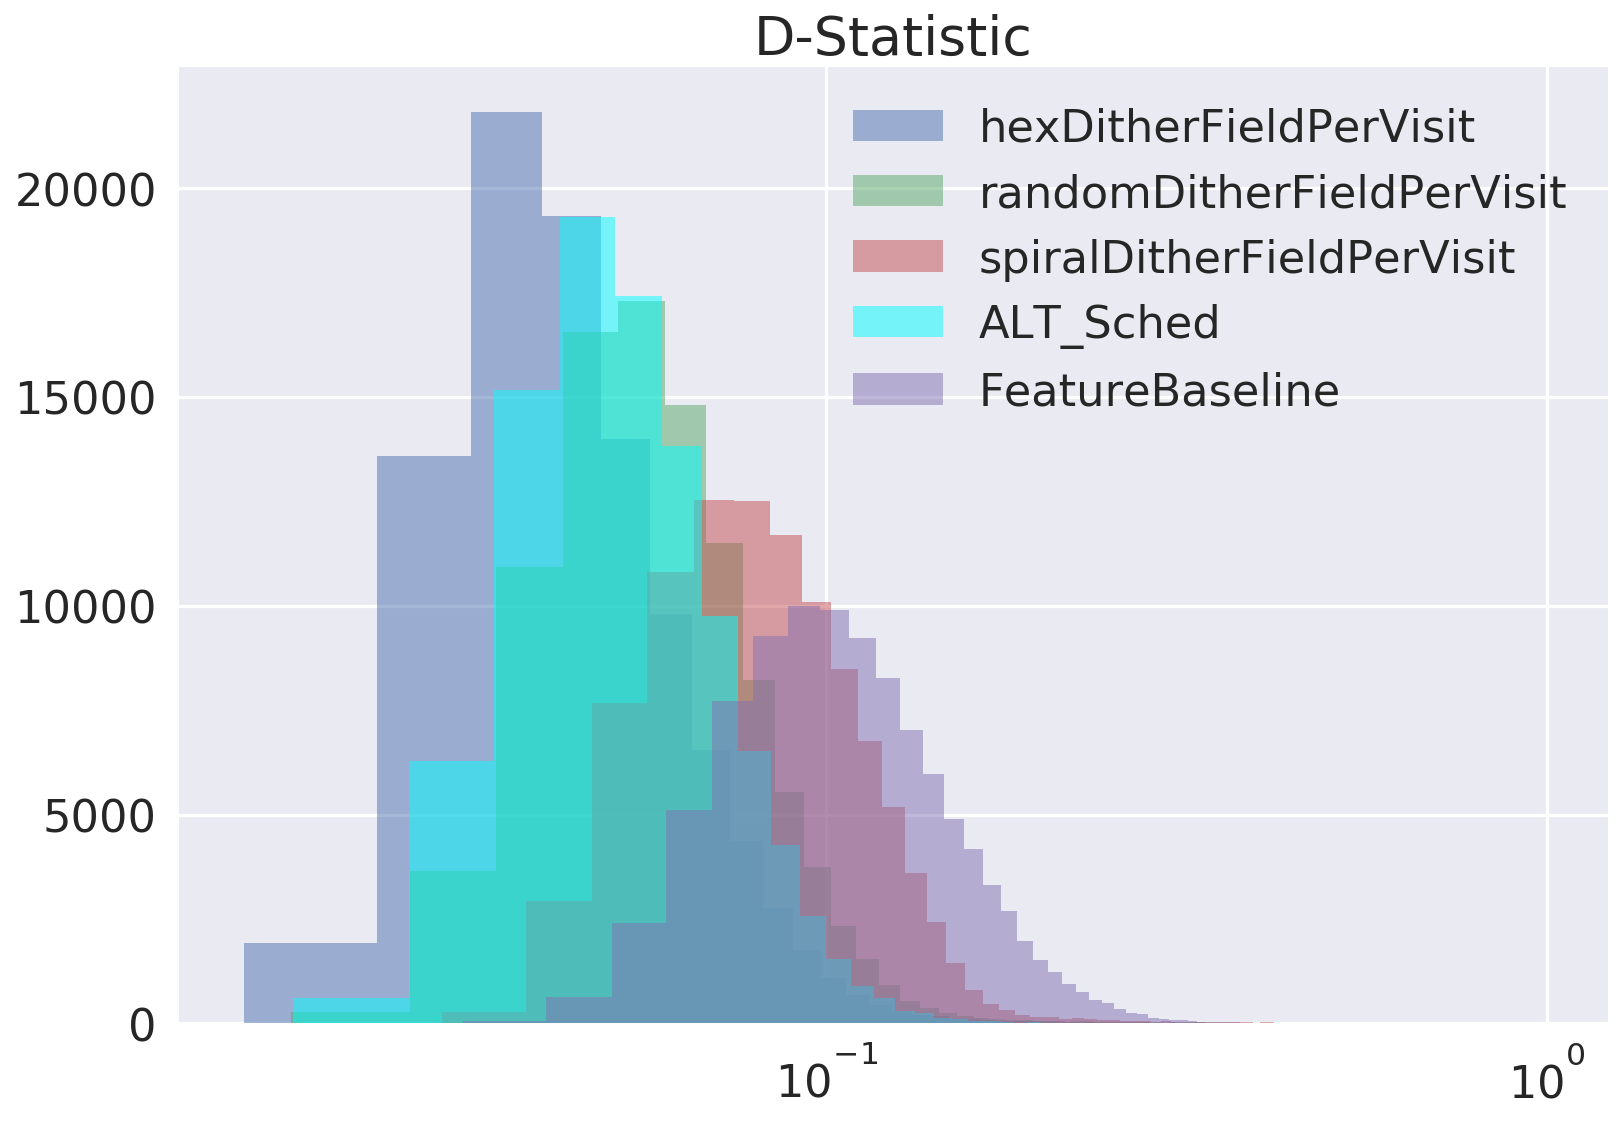

In [36]:
for run in [HexVisitY10, RandomVisitY10, SpiralVisitY10]:

    sts = []
    for angles in run.savedStarsAngles.values():
        sts.append(stats.kstest(angles,'uniform',args=(-90,180)).statistic)
    plt.hist(sts,bins=100,alpha=0.5,label=str(run.DitherPattern));
    
sts = []
for angles in ALT_SchedY10.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).statistic)
plt.hist(sts,bins=100,alpha=0.5,label='ALT_Sched',color='cyan')

sts = []
for angles in FeatureBaselineY10.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).statistic)
plt.hist(sts,bins=100,alpha=0.5,label='FeatureBaseline')

plt.title('D-Statistic');
plt.xscale('log')
plt.legend()

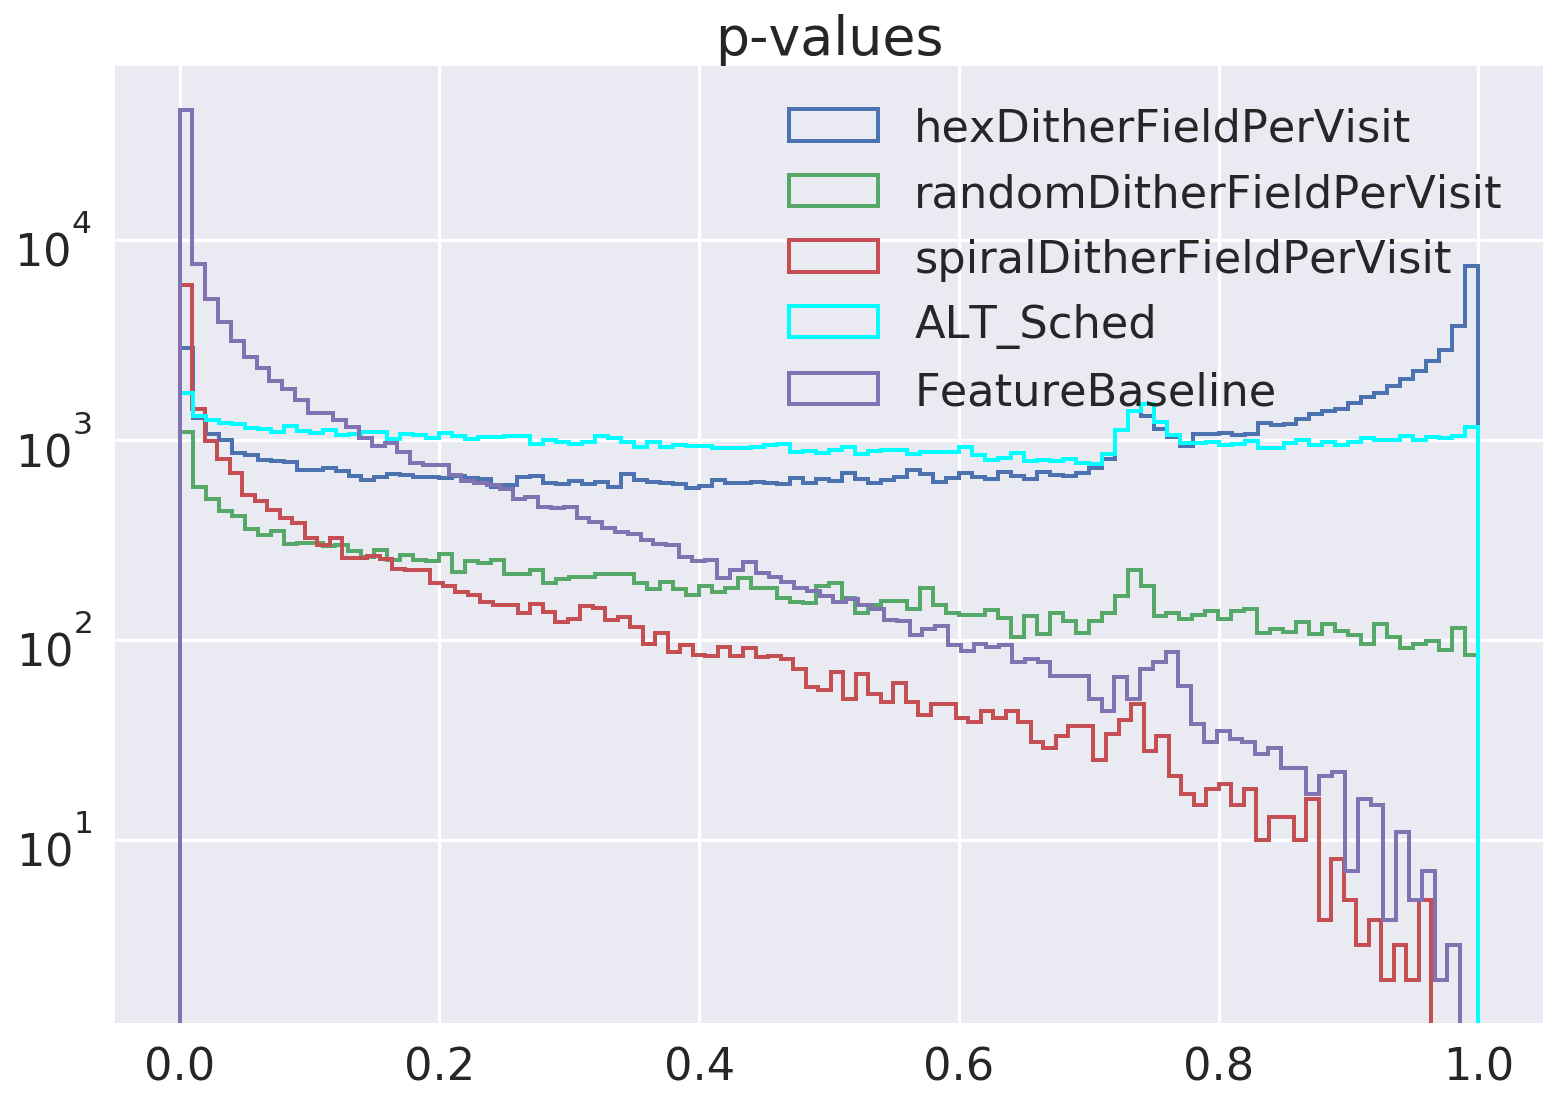

In [117]:
for run in [HexVisitY10, RandomVisitY10, SpiralVisitY10]:

    sts = []
    pvalues = []
    for angles in run.savedStarsAngles.values():
        pvalues.append(stats.kstest(angles,'uniform',args=(-90,180)).pvalue)
    plt.hist(pvalues,bins=100,label=str(run.DitherPattern), histtype='step', linewidth=2);
    plt.title('D-Statistic');
    
    
sts = []
for angles in ALT_SchedY10.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
plt.hist(sts,bins=100,label='ALT_Sched',color='cyan', histtype='step' , linewidth=2)

sts = []
for angles in FeatureBaselineY10.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
plt.hist(sts,bins=100,label='FeatureBaseline', histtype='step', linewidth=2)

plt.yscale('log')
plt.legend()
plt.title('p-values');

# Doing the same but at y1

In [ ]:
for run in [HexVisitY1, RandomVisitY1, SpiralVisitY1]:

    sts = []
    pvalues = []
    for angles in run.savedStarsAngles.values():
    #plt.hist(angles,alpha=0.2)
        pvalues.append(stats.kstest(angles,'uniform',args=(-90,180),N=10).pvalue)

    plt.hist(pvalues,bins=100,alpha=0.5,label=str(run.DitherPattern));
    plt.title('D-Statistic');
    
sts = []
for angles in ALT_SchedY1.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
plt.hist(sts,bins=100,alpha=0.5,label='ALT_Sched')

sts = []
for angles in FeatureBaselineY1.savedStarsAngles.values():
    sts.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
plt.hist(sts,bins=100,alpha=0.5,label='FeatureBaseline')


plt.legend()
plt.yscale('log')
plt.title('p-values');

## Finally, doing the same but for no dithering:

#### This is a little different to first exposures, since even without dithering on the scale of the , stars will still be seen by (very few) exposures.

In [ ]:
%%time
Y1 = ModelErrors(ModelType='radial',DitherPattern='field')
Y1.process(sqlWhere='filter = "r" and night < 3650 and propID=54')

(-60, 10)

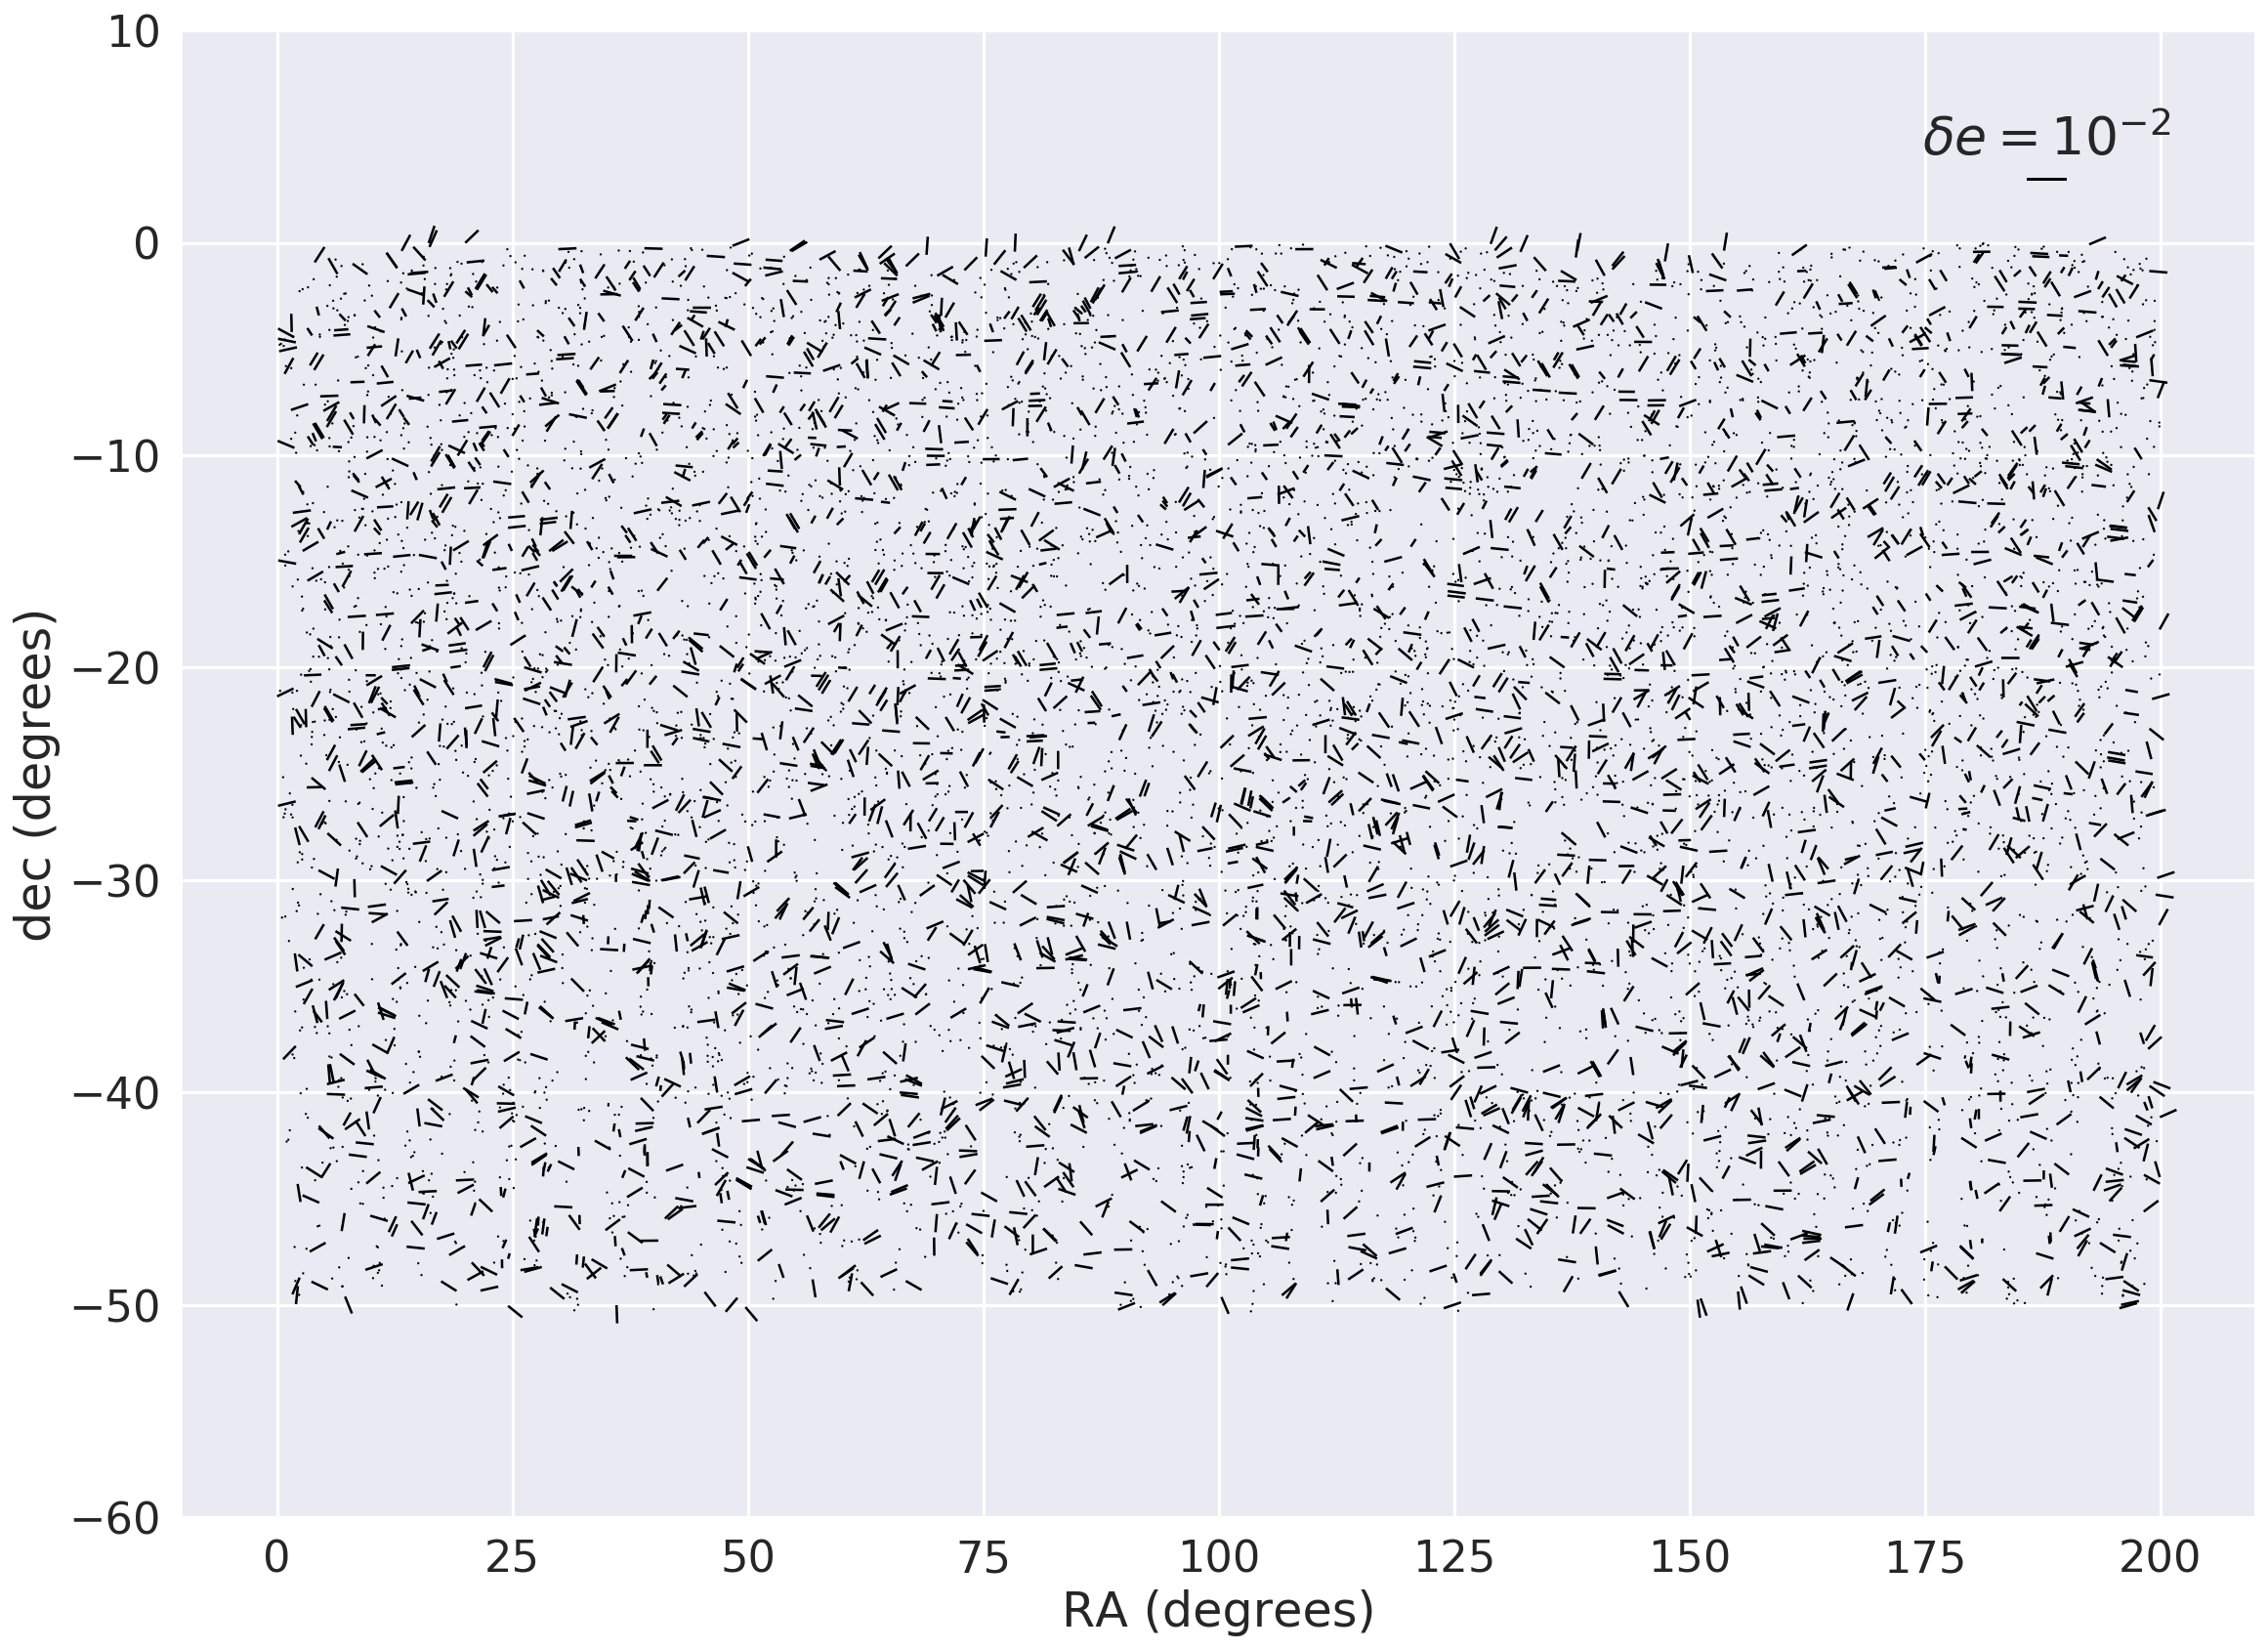

In [185]:
obj = Y1.DELTA
X = np.array(list(obj.e.keys()))[:,0]
Y = np.array(list(obj.e.keys()))[:,1]
e1 = np.array(list(obj.e.values()))[:,0]
e2 = np.array(list(obj.e.values()))[:,1]
lengths = np.sqrt(e1**2+e2**2)
angles = np.array([r2d(0.5*np.arctan2(ei2,ei1)) for ei1,ei2 in zip(e1,e2)])
pixel_scale = r2d(1)
U = lengths*np.cos(angles)
V = lengths*np.sin(angles)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,units='dots');
plt.quiverkey(Q, 0.9, 0.9, 0.01, label=r'$\delta e = 10^{-2}$', angle=0)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
plt.ylim((-60, 10))




(-60, 10)

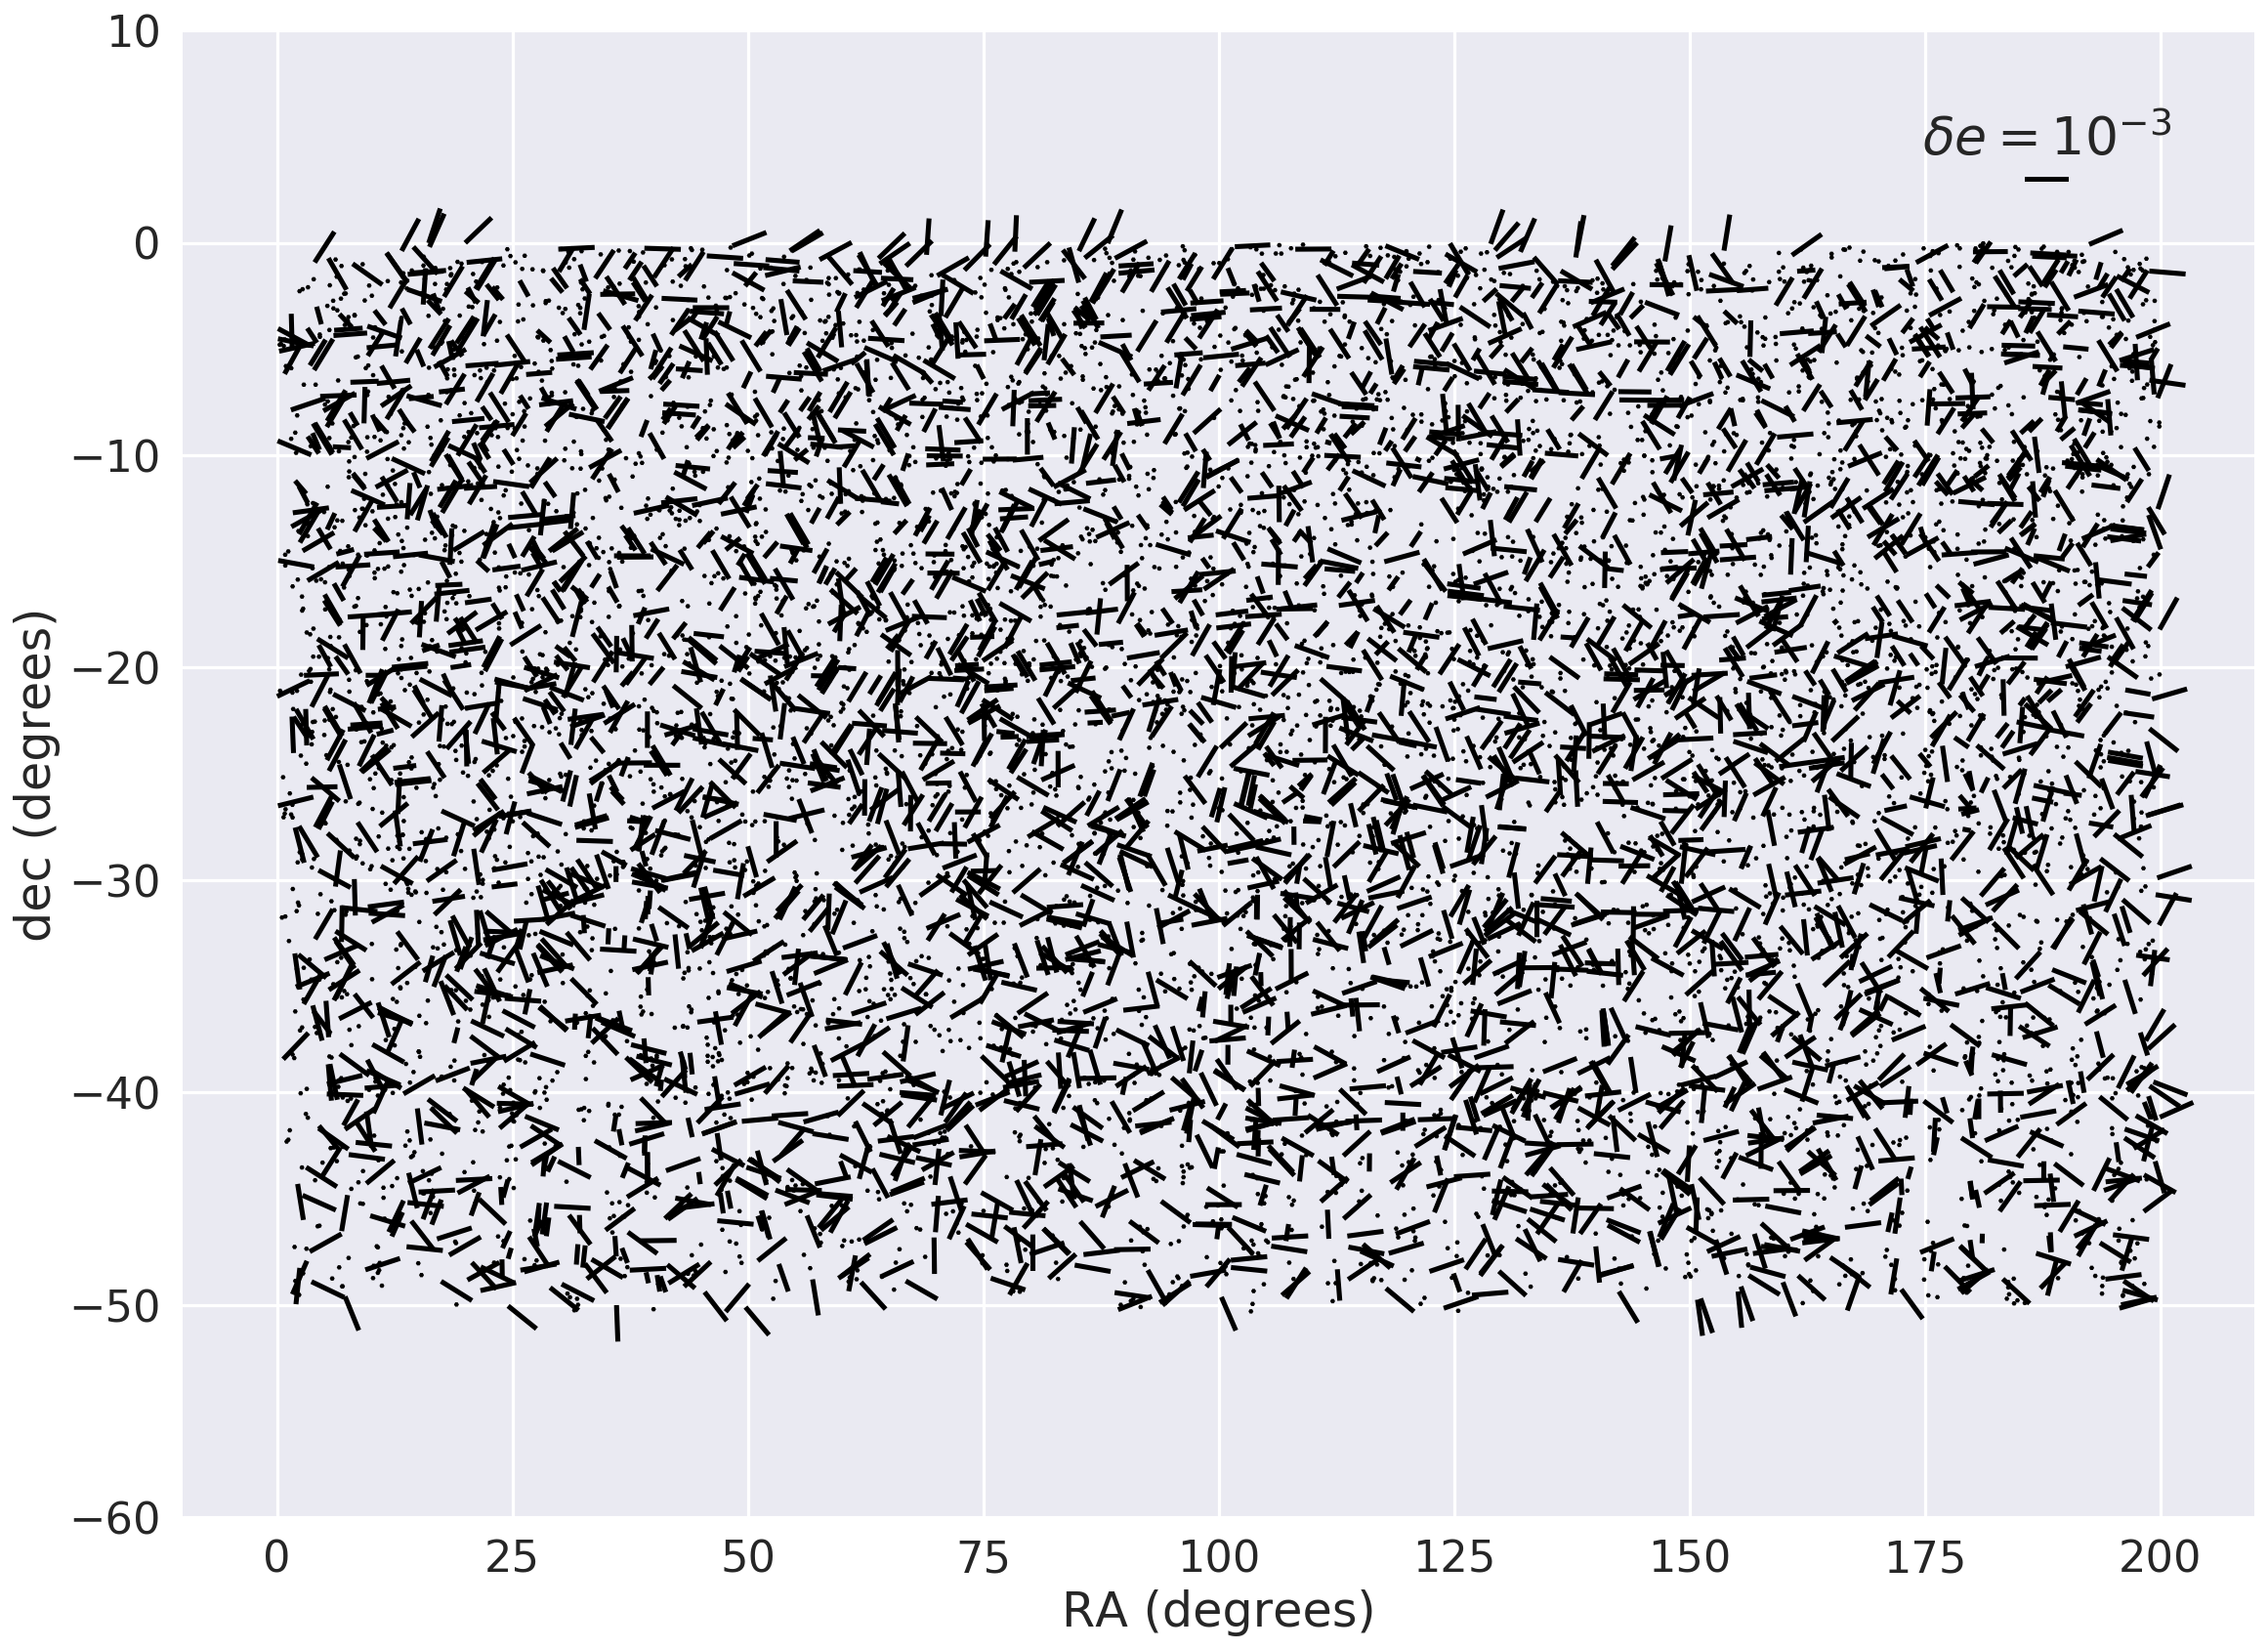

In [53]:
obj = Y1.DELTA
X = np.array(list(obj.e.keys()))[:,0]
Y = np.array(list(obj.e.keys()))[:,1]
e1 = np.array(list(obj.e.values()))[:,0]
e2 = np.array(list(obj.e.values()))[:,1]
lengths = np.sqrt(e1**2+e2**2)
angles = np.array([r2d(0.5*np.arctan2(ei2,ei1)) for ei1,ei2 in zip(e1,e2)])
pixel_scale = r2d(1)
U = lengths*np.cos(angles)
V = lengths*np.sin(angles)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,units='height');
plt.quiverkey(Q, 0.9, 0.9, 0.001/0.18457094590748474, label=r'$\delta e = 10^{-3}$', angle=0)
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
plt.ylim((-60, 10))



In [ ]:
sts1 = []
for angles in RotVisitHorizontalY10.savedStarsAngles.values():
    sts1.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
#plt.hist(sts,bins=100,alpha=0.5, label='Y10');

sts2 = []
for angles in RotVisitHorizontalY1.savedStarsAngles.values():
    sts2.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
#plt.hist(sts,bins=100,alpha=0.5, label='Y1');

sts3 = []
for angles in RotVisitHorizontalY1.savedStarsAngles.values():
    if stats.kstest(angles, 'uniform', args=(-90, 180)).pvalue > 0.5:
        pass
    else:
        sts3.append(stats.kstest(angles, 'uniform', args=(-90,180)).pvalue)
#plt.hist(sts,bins=100,alpha=0.5, label='No Dithers');

plt.legend()

plt.yscale('log')
plt.title('p-values')